In [9]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os
import errno
from IPython.display import display, HTML
import subprocess
#import pdfkit as pdf

#HTML(df.to_html())
#display(df)

hpi_red = '#b00639'
hpi_blue = '#007a9e'

def create_folder(filename):
    if not os.path.exists(os.path.dirname(filename)):
        try:
            os.makedirs(os.path.dirname(filename))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
                
def save_plot(filename):
    filename = filename.replace(" ", "_").replace(":", "_").replace(".", "_") \
                       .replace(",", "_").replace("\n", "_").replace("__", "_")
    create_folder("plots/cardinality_estimation/")
    plt.savefig('plots/cardinality_estimation/{}.pgf'.format(filename))
    plt.savefig('plots/cardinality_estimation/{}.pdf'.format(filename))
    
def data_frame_to_tex(df, filename):
    create_folder(filename)
    with open(filename, 'w') as f:
        f.write(df.to_latex())

def get_column_names(benchmark): 
    file = 'results/' + benchmark + '_results.csv.json'
    table_info = json.load(open(file,'r'))
    #print(json.dumps(table_info, indent=2, sort_keys=False))
    column_names = []
    for column in table_info["columns"]:
        column_names.append(column["name"])
    return column_names

def get_results(benchmark):
    file = 'results/' + benchmark + '_results.csv'
    return pd.read_csv(file, header=None, names=get_column_names(benchmark))

def percent(x, pos):
    'The two args are the value and tick position'
    return ('%i' % (x * 100)) + "%"

# Columns: sample_size, row_count, distinct_values, data, estimation_technique, error, occurrences 
def select(data, data_name, row_count, distinct_values, estimation_tec):
    return data[(data.row_count == row_count) &
                (data.distinct_values == distinct_values) &
                (data.data_name == data_name) & 
                (data.estimation_technique == estimation_tec)]

def get_mean_squared_error(errors, probabilities):
    mse = 0.0
    for i in range(0, len(errors)):
        error = errors.iloc[i]
        probability = probabilities.iloc[i]
        mse += probability * error * error
        
    return mse

def get_mean_error(errors, probabilities):
    me = 0.0
    for i in range(0, len(errors)):
        error = errors.iloc[i]
        probability = probabilities.iloc[i]
        me += probability * abs(error)
        #print("error: " + str(error) + ", probability: " + str(probability))
        
    return me

def estimation_evaluation(data_name, row_count, distinct_values, estimation_tec):
    #percent_formatter = FuncFormatter(percent)
    #ax.yaxis.set_major_formatter(percent_formatter)
    
    #Prepare the data
    data = get_results("estimation")
    selection = select(data, data_name, row_count, distinct_values, estimation_tec)
    if len(selection) == 0:
        return
    sample_size = selection["sample_size"].iloc[0]
    errors = selection["error"]
    probabilities = selection["occurrences"].apply(lambda x: x / sample_size)
    biggest_error = max(max(errors), 0)
    lowest_error = min(min(errors), 0)
    x_data = range(lowest_error, biggest_error + 1)
    y_data = np.zeros(biggest_error - lowest_error + 1)
    for i in range(0, len(errors)):
        y_data[errors.iloc[i] - lowest_error] = probabilities.iloc[i]     
    #one_off_probability = 0
    #if(len(y_data) > 1):
    #    one_off_probability = y_data[1]
    #correct_probability = y_data[0]
    mean_error = get_mean_error(errors, probabilities)
    mean_square_error = get_mean_squared_error(errors, probabilities)
    #filter_size_bits = pow(2, quotient_size) * (2 + remainder_size)
    #filter_size_bytes = filter_size_bits / 8
    #bits_per_value = filter_size_bits / row_count
    column_size = row_count * 2
    
    # Print some Information
    print("Estimation Technique: " + estimation_tec)
    print("Sample Size: " + str(sample_size))
    #print("One off error probability: " + str(one_off_probability))
    print("Mean Error: " + str(mean_error))
    print("Mean Squared Error: " + str(mean_square_error))
    #print("Correct " + str(correct_probability * 100) + "%" + " of the time")
    #print("Filter Size [kB]: " + str(filter_size_bytes / 1000))
    #print("Bits per Value: " + str(bits_per_value))
    print("Column Size [kB](uint16_t): "  + str(column_size / 1000))
    print("")
    
    # Configure the plot
    title = "Overcount probabilites"
    subtitle = "Value Count: " + str(row_count) \
                + ", Distinct Values: " + str(distinct_values) + ", Data: " + data_name + '\n'\
                + estimation_tec
    fig, ax = plt.subplots()
    plt.title(title + '\n' + subtitle)
    #.apply(lambda x: x * 100)
    #plt.plot(x_data[1:100], np.array(y_data[1:100]) * 100, color=hpi_red, label="estimated counts")
    plt.plot(x_data, np.array(y_data) * 100, color=hpi_red, label="estimated counts")
    plt.ylabel('Probability [%]')
    plt.xlabel('Error')
    ax.set_ylim(ymin=0, ymax=0.1)
    ax.set_xlim(xmin=-50, xmax=50)
    ax.yaxis.grid()
    ax.xaxis.grid()
    
    # Save Output
    filename = "estimation_errors_" + data_name + "_" + str(row_count) + "_" + str(distinct_values) + "_" + estimation_tec
    save_plot(filename)
    plt.show()

def estimation_example(data_name, row_count, distinct_values, estimation_tec):
    data = get_results("estimation_examples")
    selection = select(data, data_name, row_count, distinct_values, estimation_tec)
    if len(selection) == 0:
        return
    
    title = "Estimated Counts Vs. Actual Counts"
    subtitle = "Value Count: " + str(row_count) \
                + ", Distinct Values: " + str(distinct_values) + ", Data: " + data_name + '\n' \
                + estimation_tec
            
    fig, ax = plt.subplots()
    plt.title(title + '\n' + subtitle)
    plt.plot(selection["value"], selection["actual_count"], color=hpi_blue, label="Actual Counts")
    plt.plot(selection["value"], selection["estimated_count"], color=hpi_red, label="Estimated Counts")
    plt.legend(loc='upper left')
    plt.ylabel('Value Count')
    plt.xlabel('Distinct Values')
    ax.set_ylim(ymin=0)
    ax.set_xlim(xmin=0)
    ax.set_xlim(xmax=distinct_values)
    filename = "estimation_example_" + data_name + "_" + str(row_count) + "_" + str(distinct_values) + "_" + estimation_tec
    save_plot(filename)
    plt.show()
    
    max_error = 0
    max_rel_error = 0
    for i in range(0, len(selection)):
        estimated_count = selection["estimated_count"].iloc[i]
        actual_count = selection["actual_count"].iloc[i]
        abs_error = abs(estimated_count - actual_count)
        rel_error = (abs_error / actual_count)
        if abs_error > max_error:
            max_error = abs_error
        if rel_error > max_rel_error and actual_count != 0:
            max_rel_error = rel_error
            
    print("max error: " + str(max_error))
    print("max relative error: " + str(max_rel_error * 100) + "%")
     
def complete_estimation_table(data_name, row_count, distinct_count):
    remainder_sizes = [2, 4, 8, 16]
    quotient_sizes = [12, 13, 14, 15, 16, 17]
    granularities = [10, 50, 100]
    estimation_tecs = []
    
    estimation_tecs.append("uniform")
    
    for postgres_method in [1, 2]:
        for granularity in granularities:
            estimation_tec = "postgres" + str(postgres_method) + "_" + str(granularity)
            estimation_tecs.append(estimation_tec)
        
    for quotient_size in quotient_sizes:
        for remainder_size in remainder_sizes:
            estimation_tec = "filter_" + str(quotient_size) + "_" + str(remainder_size)
            estimation_tecs.append(estimation_tec)
            
    estimation_comparison_table(estimation_tecs, data_name, row_count, distinct_values, "complete")
    
def filter_estimation_table(data_name, row_count, distinct_count):
    remainder_sizes = [2, 4, 8, 16]
    quotient_sizes = [12, 13, 14, 15, 16, 17]
    estimation_tecs = []

    for quotient_size in quotient_sizes:
        for remainder_size in remainder_sizes:
            estimation_tec = "filter_" + str(quotient_size) + "_" + str(remainder_size)
            estimation_tecs.append(estimation_tec)
            
    estimation_comparison_table(estimation_tecs, data_name, row_count, distinct_values, "filter")
    
def estimation_memory_consumption(estimation_tec):
    parts = estimation_tec.split("_")
    if parts[0] == "filter":
        quotient_size = int(parts[1])
        remainder_size = int(parts[2])    
        filter_size_bits = pow(2, quotient_size) * (2 + remainder_size)
        filter_size_bytes = filter_size_bits / 8
        return filter_size_bytes
    
    if parts[0] == "postgres1" or parts[0] == "postgres2":
        granularity = int(parts[1])
        return granularity * 4
    
    if parts[0] == "uniform":
        return 1
    
def estimation_comparison_table(estimation_tecs, data_name, row_count, distinct_values, table_name):
    data = get_results("estimation")
    table = []
    for estimation_tec in estimation_tecs:
        selection = select(data, data_name, row_count, distinct_values, estimation_tec)
        if len(selection) > 0:
            sample_size = selection["sample_size"].iloc[0]
            x_data = selection["error"]
            y_data = selection["occurrences"].apply(lambda x: x / sample_size)
            memory_consumption = estimation_memory_consumption(estimation_tec)
            mean_error = get_mean_error(x_data, y_data)
            mean_squared_error = get_mean_squared_error(x_data, y_data)
            table.append((estimation_tec, memory_consumption, mean_error, mean_squared_error))

    columns = ["Estimation Technique", "Memory Consumption", "Mean Error", "Mean Squared Error"]
    df = pd.DataFrame(table, columns=columns)
    #display(df.sort_values(by=["Bits per Value"]))
    display(df)
    file_name = data_name + str(distinct_values) + "_" + table_name + "_estimation_table"
    data_frame_to_tex(df, 'plots/cardinality_estimation/{}.tex'.format(file_name))
    
def filter_names(quotient_sizes, remainder_sizes):
    names = []
    for quotient_size in quotient_sizes:
        for remainder_size in remainder_sizes:
            estimation_tec = "filter_" + str(quotient_size) + "_" + str(remainder_size)
            names.append(estimation_tec)
    return names
    

In [3]:
# Generate a comparison table
row_count = 100000
distinct_values = 3000
data_name = "normal_shuffled"
complete_estimation_table(data_name, row_count, distinct_values)
filter_estimation_table(data_name, row_count, distinct_values)

Estimation Technique  Memory Consumption  Mean Error  Mean Squared Error
0               uniform                 1.0   24.865667          775.522333
1          postgres1_10                40.0   24.846667          773.792667
2          postgres1_50               200.0   24.839667          795.842333
3         postgres1_100               400.0   24.245000          755.104333
4          postgres2_10                40.0   24.709000          768.159000
5          postgres2_50               200.0   23.966333          739.608333
6         postgres2_100               400.0   23.166333          701.208333
7           filter_14_4             12288.0    0.377215           21.485537
8           filter_14_8             20480.0    0.025324            1.434645
9          filter_14_16             36864.0    0.000215            0.014979
10          filter_15_2             16384.0    0.751808           42.895548
11          filter_15_4             24576.0    0.188443           10.810421
12          filter_15_8             40960.0    0.012400            0.712565
13         filter_15_16             73728.0    0.000165            0.011317
14          filter_16_2             32768.0    0.372522           21.113064
15          filter_16_4             49152.0    0.091282            5.187572
16          filter_16_8             81920.0    0.006012            0.344481
17         filter_16_16            147456.0    0.000107            0.007489

Estimation Technique  Memory Consumption  Mean Error  Mean Squared Error
0           filter_14_4             12288.0    0.377215           21.485537
1           filter_14_8             20480.0    0.025324            1.434645
2          filter_14_16             36864.0    0.000215            0.014979
3           filter_15_2             16384.0    0.751808           42.895548
4           filter_15_4             24576.0    0.188443           10.810421
5           filter_15_8             40960.0    0.012400            0.712565
6          filter_15_16             73728.0    0.000165            0.011317
7           filter_16_2             32768.0    0.372522           21.113064
8           filter_16_4             49152.0    0.091282            5.187572
9           filter_16_8             81920.0    0.006012            0.344481
10         filter_16_16            147456.0    0.000107            0.007489

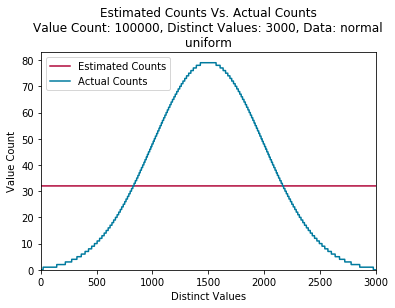

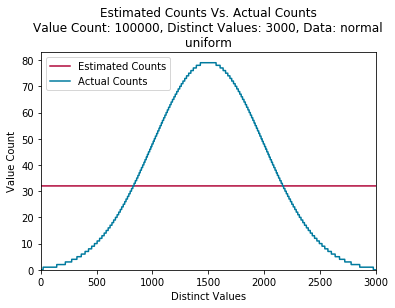

C:\Users\Arne\Anaconda3\lib\site-packages\ipykernel_launcher.py:170: RuntimeWarning: divide by zero encountered in longlong_scalars


max error: 47
max relative error: 3100.0%
Estimation Technique: uniform
Sample Size: 3000
Mean Error: 24.8656666667
Mean Squared Error: 775.522333333
Column Size [kB](uint16_t): 200.0



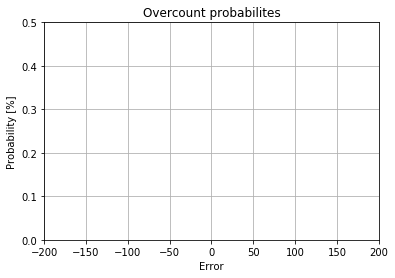

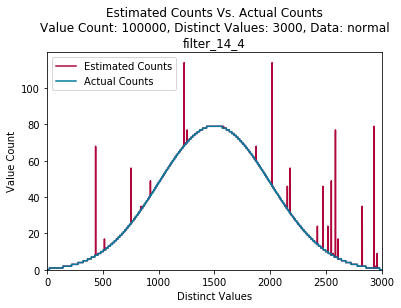

C:\Users\Arne\Anaconda3\lib\site-packages\ipykernel_launcher.py:170: RuntimeWarning: invalid value encountered in longlong_scalars


max error: 78
max relative error: 7800.0%
Estimation Technique: filter_14_4
Sample Size: 3000000
Mean Error: 0.377017
Mean Squared Error: 21.4614176667
Column Size [kB](uint16_t): 200.0



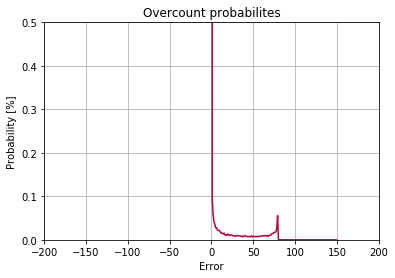

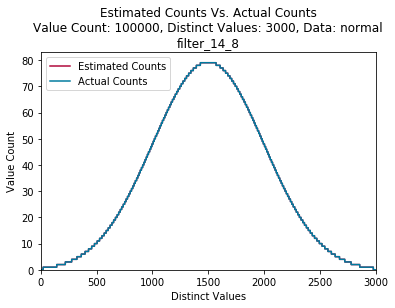

max error: 0
max relative error: 0%
Estimation Technique: filter_14_8
Sample Size: 3000000
Mean Error: 0.0237996666667
Mean Squared Error: 1.35995233333
Column Size [kB](uint16_t): 200.0



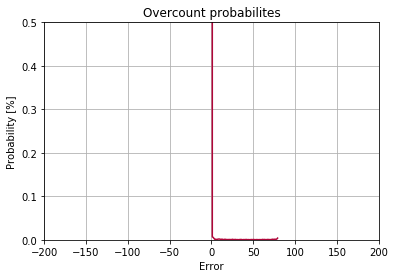

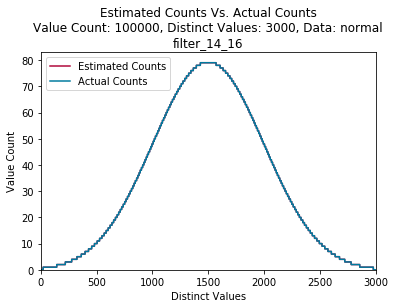

max error: 0
max relative error: 0%
Estimation Technique: filter_14_16
Sample Size: 3000000
Mean Error: 4e-05
Mean Squared Error: 0.00178066666667
Column Size [kB](uint16_t): 200.0



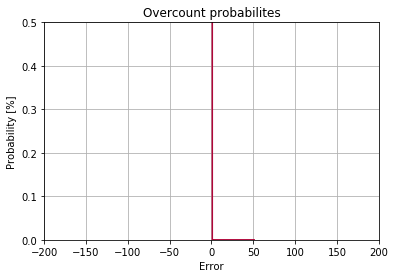

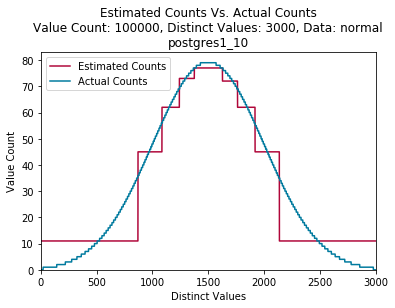

max error: 25
max relative error: 1000.0%
Estimation Technique: postgres1_10
Sample Size: 3000
Mean Error: 6.331
Mean Squared Error: 66.339
Column Size [kB](uint16_t): 200.0



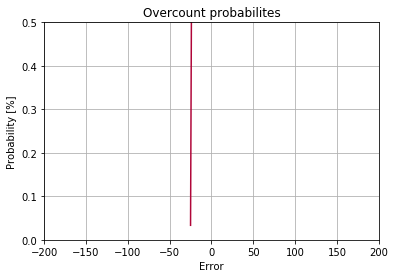

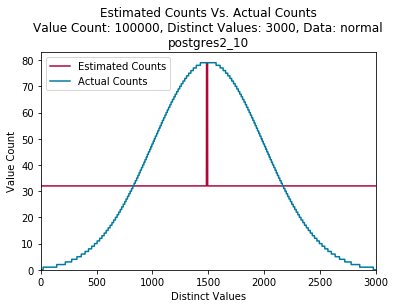

max error: 47
max relative error: 3100.0%
Estimation Technique: postgres2_10
Sample Size: 3000
Mean Error: 24.709
Mean Squared Error: 768.159
Column Size [kB](uint16_t): 200.0



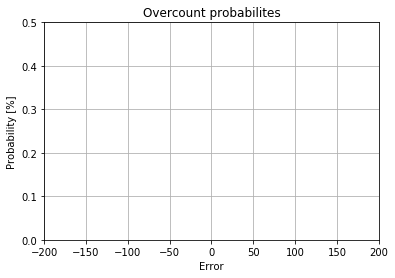

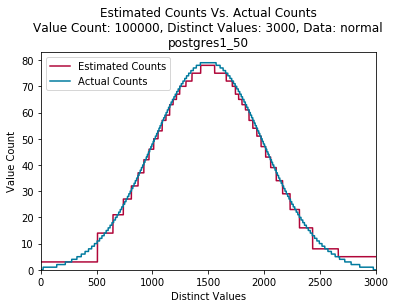

max error: 8
max relative error: 400.0%
Estimation Technique: postgres1_50
Sample Size: 3000
Mean Error: 1.92833333333
Mean Squared Error: 5.569
Column Size [kB](uint16_t): 200.0



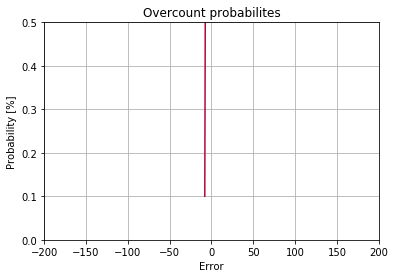

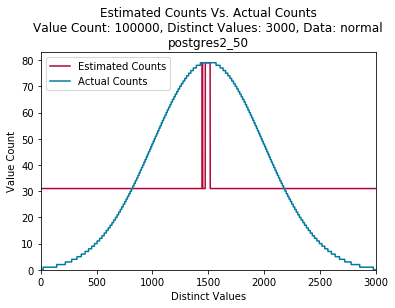

max error: 48
max relative error: 3000.0%
Estimation Technique: postgres2_50
Sample Size: 3000
Mean Error: 23.9663333333
Mean Squared Error: 739.608333333
Column Size [kB](uint16_t): 200.0



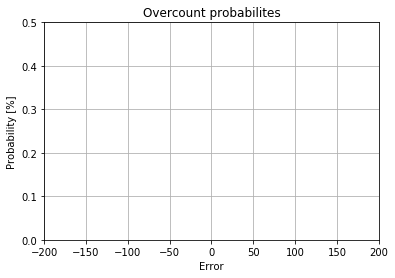

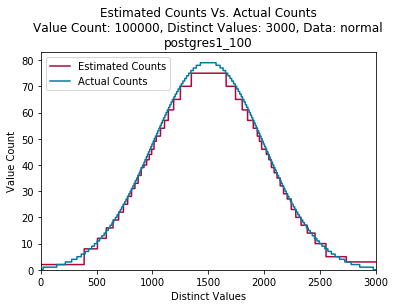

max error: 6
max relative error: 200.0%
Estimation Technique: postgres1_100
Sample Size: 3000
Mean Error: 1.701
Mean Squared Error: 4.51633333333
Column Size [kB](uint16_t): 200.0



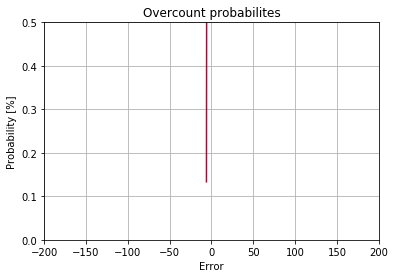

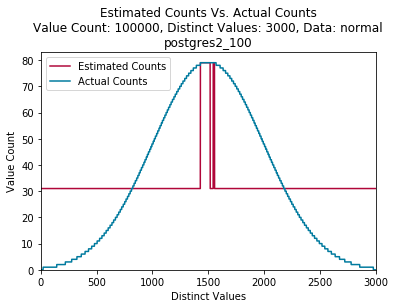

max error: 48
max relative error: 3000.0%
Estimation Technique: postgres2_100
Sample Size: 3000
Mean Error: 23.1663333333
Mean Squared Error: 701.208333333
Column Size [kB](uint16_t): 200.0



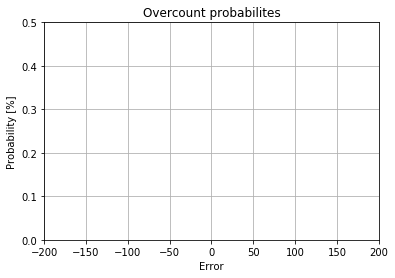

In [6]:
# Generate a selection of plots
remainder_sizes = [2, 4, 8, 16]
quotient_sizes = [14]
postgres_granularities = [10, 50, 100]
data_name = "normal"
row_count = 100000
distinct_values = 3000

estimation_example(data_name, row_count, distinct_values, "uniform")
estimation_evaluation(data_name, row_count, distinct_values, "uniform")

for estimation_tec in filter_names(quotient_sizes, remainder_sizes):        
        estimation_example(data_name, row_count, distinct_values, estimation_tec)
        estimation_evaluation(data_name, row_count, distinct_values, estimation_tec)
        
for granularity in postgres_granularities:
    estimation_tec = "postgres1_" + str(granularity)
    estimation_example(data_name, row_count, distinct_values, estimation_tec)    
    estimation_evaluation(data_name, row_count, distinct_values, estimation_tec)
    estimation_tec = "postgres2_" + str(granularity)
    estimation_example(data_name, row_count, distinct_values, estimation_tec)
    estimation_evaluation(data_name, row_count, distinct_values, estimation_tec)

Estimation Technique  Memory Consumption  Mean Error  Mean Squared Error
0               uniform                 1.0   24.865667          775.522333
1          postgres1_10                40.0    6.331000           66.339000
2          postgres1_50               200.0    1.928333            5.569000
3         postgres1_100               400.0    1.701000            4.516333
4          postgres2_10                40.0   24.709000          768.159000
5          postgres2_50               200.0   23.966333          739.608333
6         postgres2_100               400.0   23.166333          701.208333
7           filter_14_4             12288.0    0.377017           21.461418
8           filter_14_8             20480.0    0.023800            1.359952
9          filter_14_16             36864.0    0.000040            0.001781
10          filter_15_2             16384.0    0.753382           42.968323
11          filter_15_4             24576.0    0.188599           10.755025
12          filter_15_8             40960.0    0.011787            0.674989
13         filter_15_16             73728.0    0.000018            0.000839
14          filter_16_2             32768.0    0.374739           21.330099
15          filter_16_4             49152.0    0.091322            5.164568
16          filter_16_8             81920.0    0.005875            0.338202
17         filter_16_16            147456.0    0.000102            0.004503

Estimation Technique  Memory Consumption  Mean Error  Mean Squared Error
0           filter_14_4             12288.0    0.377017           21.461418
1           filter_14_8             20480.0    0.023800            1.359952
2          filter_14_16             36864.0    0.000040            0.001781
3           filter_15_2             16384.0    0.753382           42.968323
4           filter_15_4             24576.0    0.188599           10.755025
5           filter_15_8             40960.0    0.011787            0.674989
6          filter_15_16             73728.0    0.000018            0.000839
7           filter_16_2             32768.0    0.374739           21.330099
8           filter_16_4             49152.0    0.091322            5.164568
9           filter_16_8             81920.0    0.005875            0.338202
10         filter_16_16            147456.0    0.000102            0.004503

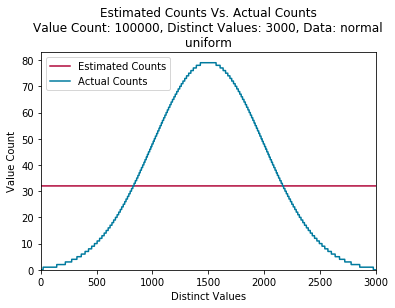

C:\Users\Arne\Anaconda3\lib\site-packages\ipykernel_launcher.py:170: RuntimeWarning: divide by zero encountered in longlong_scalars


max error: 47
max relative error: 3100.0%
Estimation Technique: uniform
Sample Size: 3000
Mean Error: 24.8656666667
Mean Squared Error: 775.522333333
Column Size [kB](uint16_t): 200.0



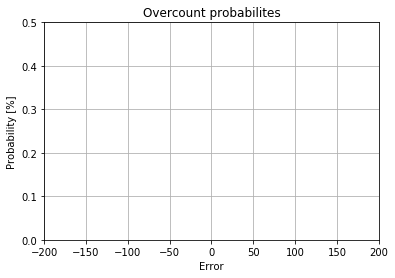

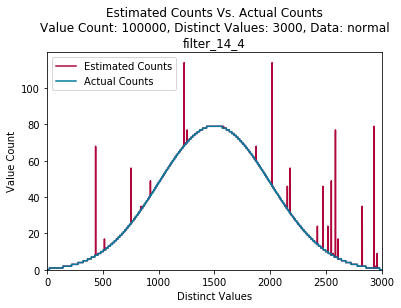

C:\Users\Arne\Anaconda3\lib\site-packages\ipykernel_launcher.py:170: RuntimeWarning: invalid value encountered in longlong_scalars


max error: 78
max relative error: 7800.0%
Estimation Technique: filter_14_4
Sample Size: 3000000
Mean Error: 0.377017
Mean Squared Error: 21.4614176667
Column Size [kB](uint16_t): 200.0



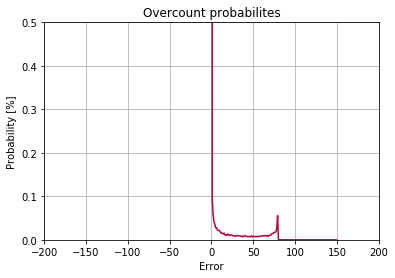

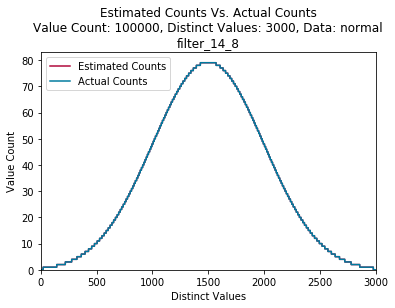

max error: 0
max relative error: 0%
Estimation Technique: filter_14_8
Sample Size: 3000000
Mean Error: 0.0237996666667
Mean Squared Error: 1.35995233333
Column Size [kB](uint16_t): 200.0



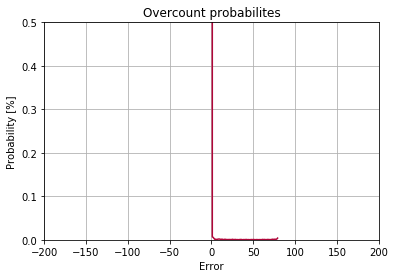

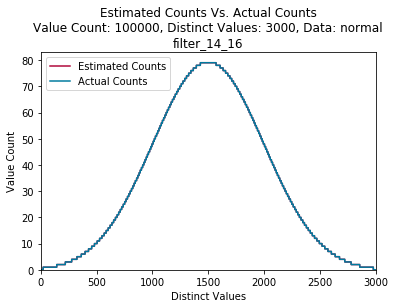

max error: 0
max relative error: 0%
Estimation Technique: filter_14_16
Sample Size: 3000000
Mean Error: 4e-05
Mean Squared Error: 0.00178066666667
Column Size [kB](uint16_t): 200.0



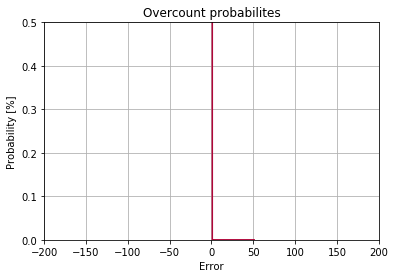

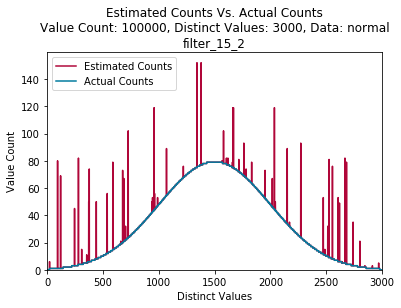

max error: 79
max relative error: 7900.0%
Estimation Technique: filter_15_2
Sample Size: 3000000
Mean Error: 0.753382
Mean Squared Error: 42.9683233333
Column Size [kB](uint16_t): 200.0



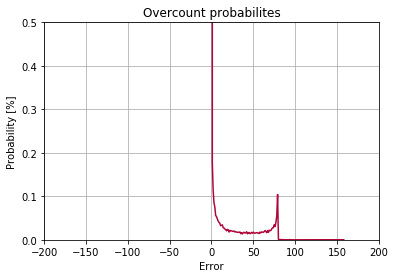

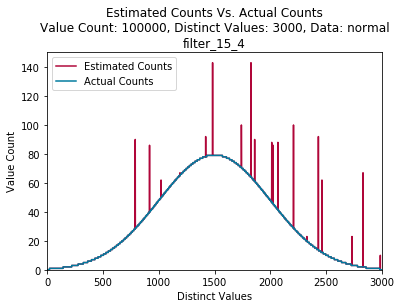

max error: 79
max relative error: 3250.0%
Estimation Technique: filter_15_4
Sample Size: 3000000
Mean Error: 0.188599333333
Mean Squared Error: 10.7550246667
Column Size [kB](uint16_t): 200.0



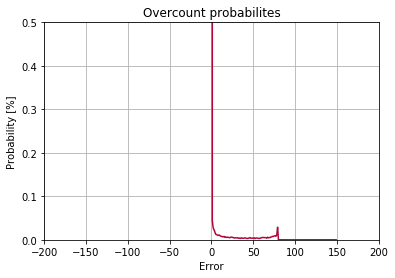

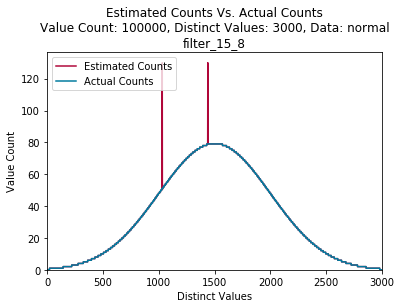

max error: 79
max relative error: 154.901960784%
Estimation Technique: filter_15_8
Sample Size: 3000000
Mean Error: 0.0117866666667
Mean Squared Error: 0.674988666667
Column Size [kB](uint16_t): 200.0



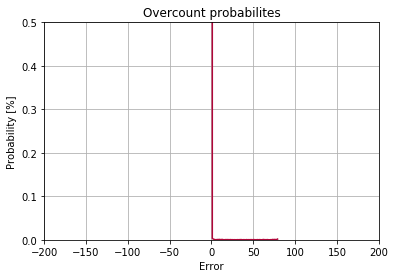

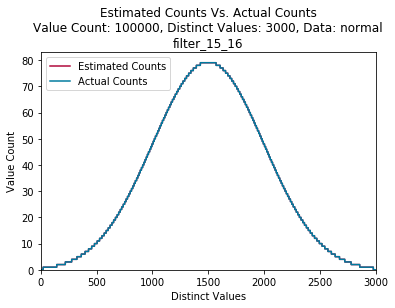

max error: 0
max relative error: 0%
Estimation Technique: filter_15_16
Sample Size: 3000000
Mean Error: 1.8e-05
Mean Squared Error: 0.000838666666667
Column Size [kB](uint16_t): 200.0



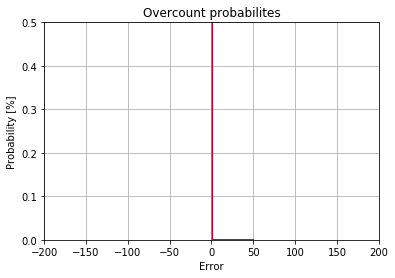

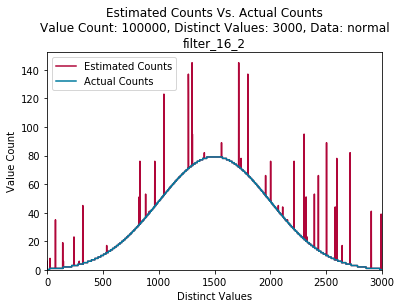

max error: 79
max relative error: 4000.0%
Estimation Technique: filter_16_2
Sample Size: 3000000
Mean Error: 0.374738666667
Mean Squared Error: 21.3300993333
Column Size [kB](uint16_t): 200.0



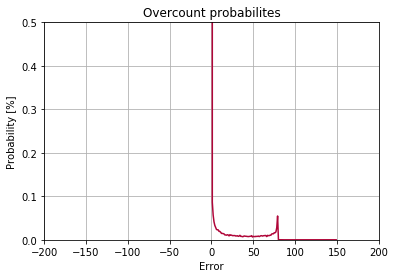

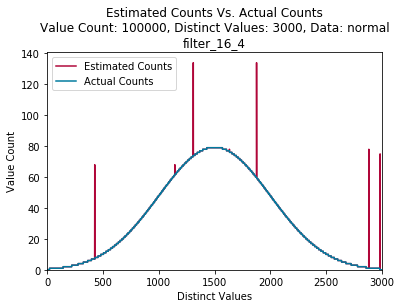

max error: 77
max relative error: 7700.0%
Estimation Technique: filter_16_4
Sample Size: 3000000
Mean Error: 0.091322
Mean Squared Error: 5.164568
Column Size [kB](uint16_t): 200.0



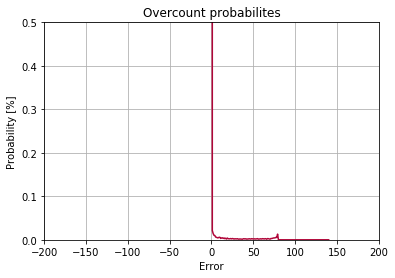

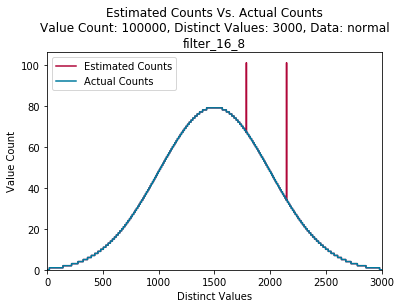

max error: 67
max relative error: 197.058823529%
Estimation Technique: filter_16_8
Sample Size: 3000000
Mean Error: 0.00587466666667
Mean Squared Error: 0.338202
Column Size [kB](uint16_t): 200.0



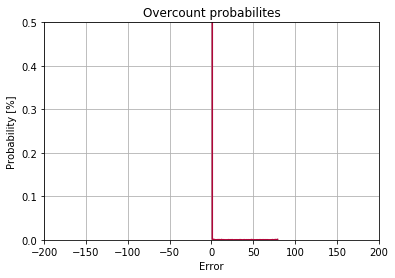

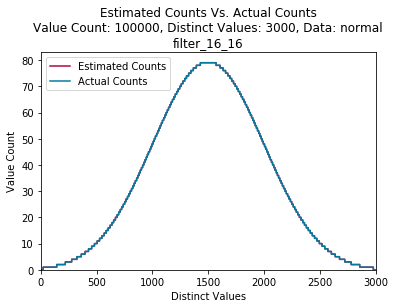

max error: 0
max relative error: 0%
Estimation Technique: filter_16_16
Sample Size: 3000000
Mean Error: 0.000102
Mean Squared Error: 0.00450333333333
Column Size [kB](uint16_t): 200.0



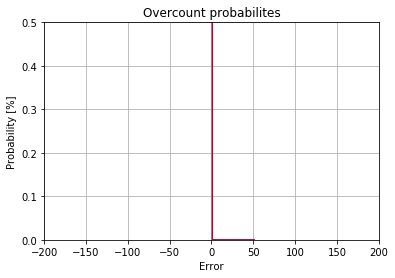

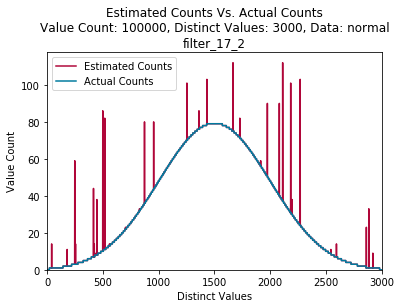

max error: 79
max relative error: 3200.0%
Estimation Technique: filter_17_2
Sample Size: 3000000
Mean Error: 0.187801333333
Mean Squared Error: 10.7292406667
Column Size [kB](uint16_t): 200.0



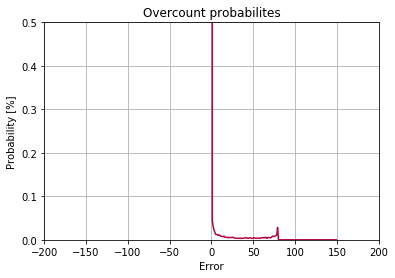

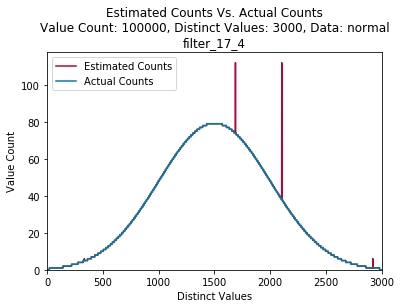

max error: 74
max relative error: 500.0%
Estimation Technique: filter_17_4
Sample Size: 3000000
Mean Error: 0.0534863333333
Mean Squared Error: 3.06493966667
Column Size [kB](uint16_t): 200.0



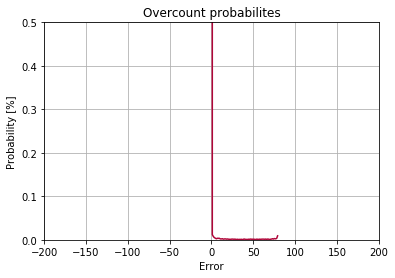

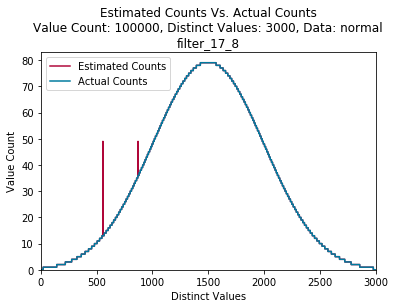

max error: 36
max relative error: 276.923076923%
Estimation Technique: filter_17_8
Sample Size: 3000000
Mean Error: 0.002956
Mean Squared Error: 0.158867333333
Column Size [kB](uint16_t): 200.0



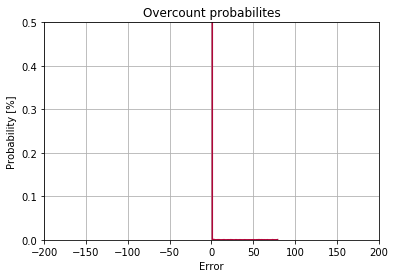

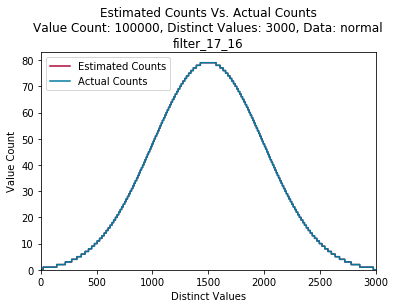

max error: 0
max relative error: 0%
Estimation Technique: filter_17_16
Sample Size: 3000000
Mean Error: 0.00016
Mean Squared Error: 0.00712266666667
Column Size [kB](uint16_t): 200.0



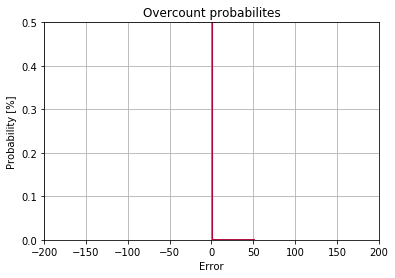

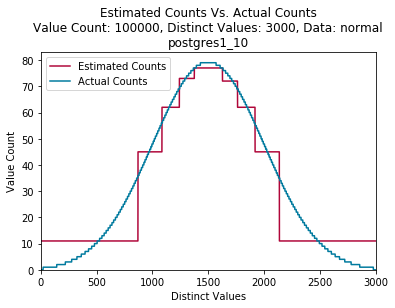

max error: 25
max relative error: 1000.0%
Estimation Technique: postgres1_10
Sample Size: 3000
Mean Error: 6.331
Mean Squared Error: 66.339
Column Size [kB](uint16_t): 200.0



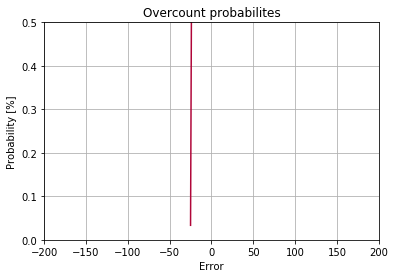

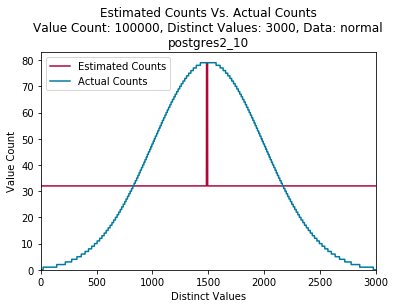

max error: 47
max relative error: 3100.0%
Estimation Technique: postgres2_10
Sample Size: 3000
Mean Error: 24.709
Mean Squared Error: 768.159
Column Size [kB](uint16_t): 200.0



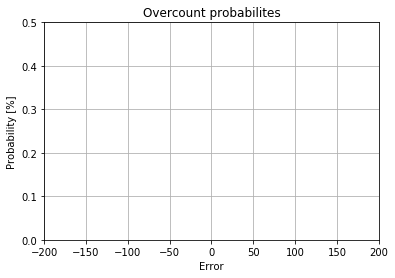

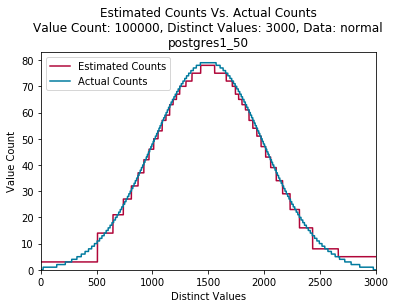

max error: 8
max relative error: 400.0%
Estimation Technique: postgres1_50
Sample Size: 3000
Mean Error: 1.92833333333
Mean Squared Error: 5.569
Column Size [kB](uint16_t): 200.0



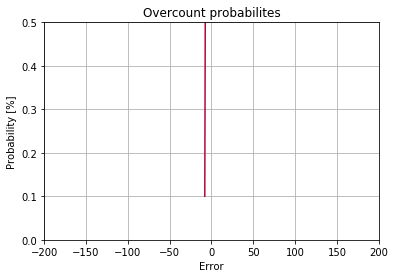

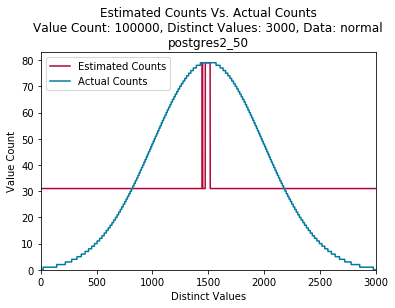

max error: 48
max relative error: 3000.0%
Estimation Technique: postgres2_50
Sample Size: 3000
Mean Error: 23.9663333333
Mean Squared Error: 739.608333333
Column Size [kB](uint16_t): 200.0



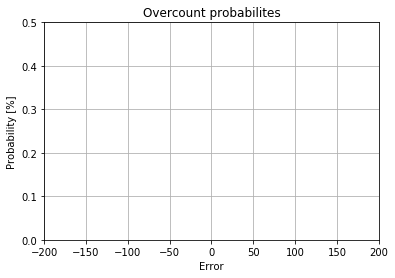

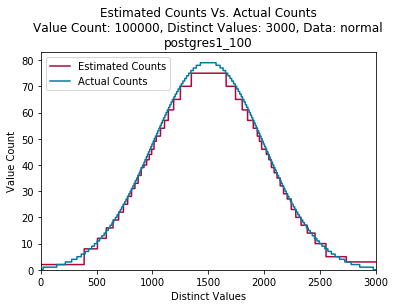

max error: 6
max relative error: 200.0%
Estimation Technique: postgres1_100
Sample Size: 3000
Mean Error: 1.701
Mean Squared Error: 4.51633333333
Column Size [kB](uint16_t): 200.0



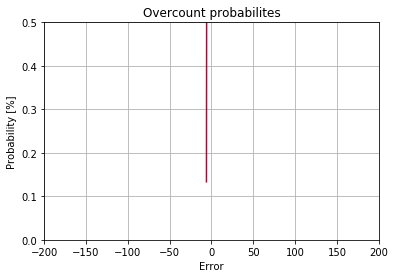

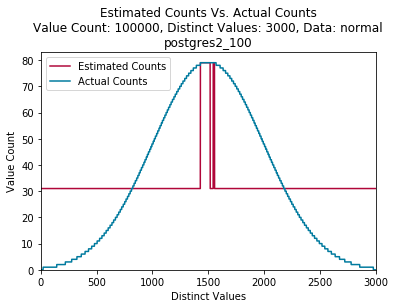

max error: 48
max relative error: 3000.0%
Estimation Technique: postgres2_100
Sample Size: 3000
Mean Error: 23.1663333333
Mean Squared Error: 701.208333333
Column Size [kB](uint16_t): 200.0



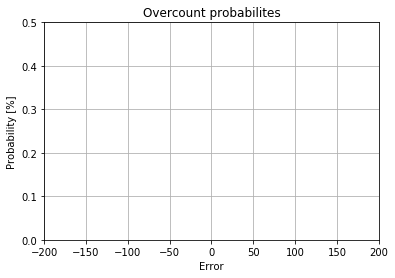

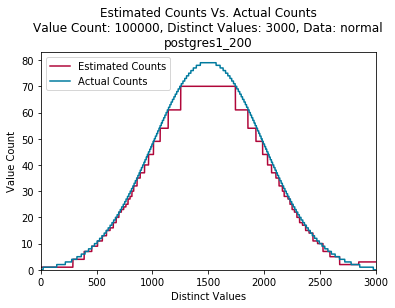

max error: 9
max relative error: 200.0%
Estimation Technique: postgres1_200
Sample Size: 3000
Mean Error: 2.539
Mean Squared Error: 12.9923333333
Column Size [kB](uint16_t): 200.0



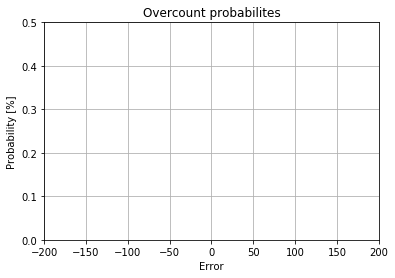

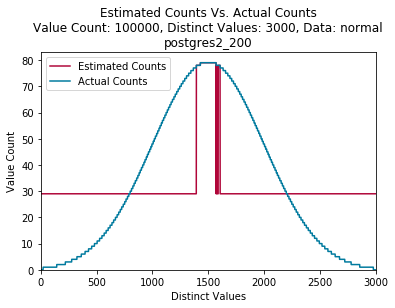

max error: 49
max relative error: 2800.0%
Estimation Technique: postgres2_200
Sample Size: 3000
Mean Error: 21.302
Mean Squared Error: 624.260666667
Column Size [kB](uint16_t): 200.0



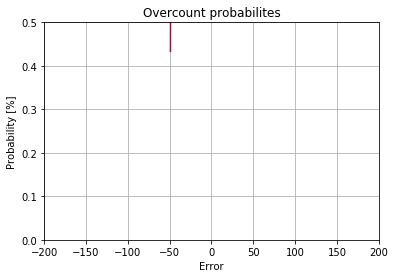

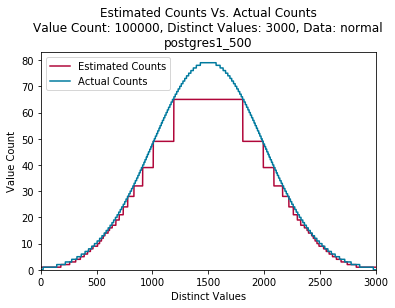

max error: 16
max relative error: 50.0%
Estimation Technique: postgres1_500
Sample Size: 3000
Mean Error: 3.96933333333
Mean Squared Error: 37.2013333333
Column Size [kB](uint16_t): 200.0



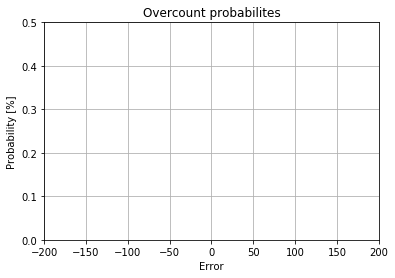

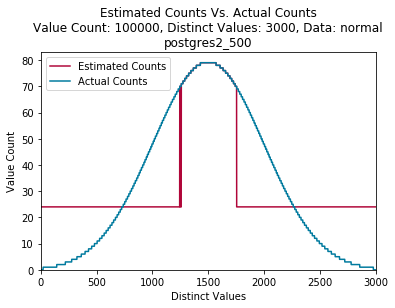

max error: 46
max relative error: 2300.0%
Estimation Technique: postgres2_500
Sample Size: 3000
Mean Error: 15.848
Mean Squared Error: 398.416666667
Column Size [kB](uint16_t): 200.0



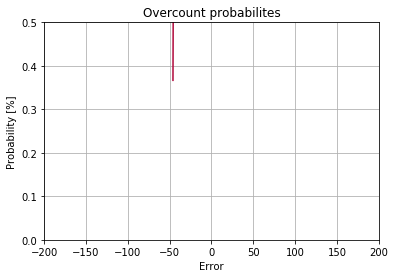

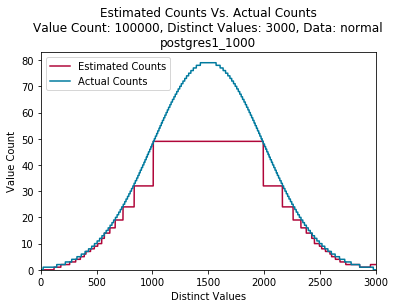

max error: 30
max relative error: 100.0%
Estimation Technique: postgres1_1000
Sample Size: 3000
Mean Error: 8.01766666667
Mean Squared Error: 161.659666667
Column Size [kB](uint16_t): 200.0



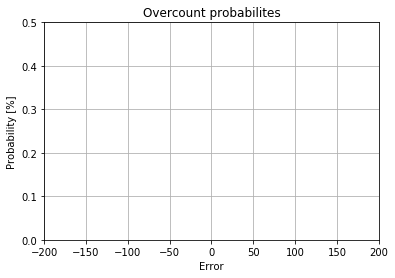

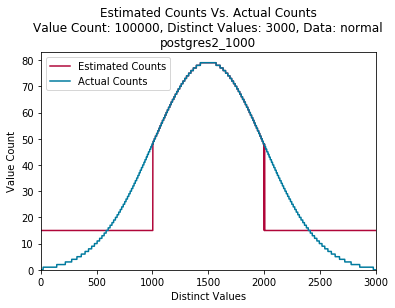

max error: 33
max relative error: 1400.0%
Estimation Technique: postgres2_1000
Sample Size: 3000
Mean Error: 7.93933333333
Mean Squared Error: 130.826666667
Column Size [kB](uint16_t): 200.0



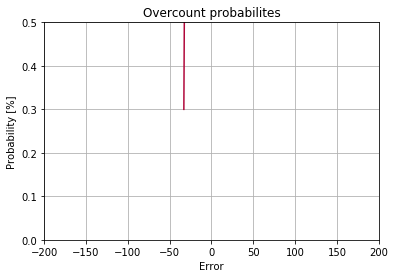

Estimation Technique  Memory Consumption  Mean Error  Mean Squared Error
0               uniform                 1.0   24.865667          775.522333
1          postgres1_10                40.0   24.846667          773.792667
2          postgres1_50               200.0   24.839667          795.842333
3         postgres1_100               400.0   24.245000          755.104333
4          postgres2_10                40.0   24.709000          768.159000
5          postgres2_50               200.0   23.966333          739.608333
6         postgres2_100               400.0   23.166333          701.208333
7           filter_14_4             12288.0    0.377215           21.485537
8           filter_14_8             20480.0    0.025324            1.434645
9          filter_14_16             36864.0    0.000215            0.014979
10          filter_15_2             16384.0    0.751808           42.895548
11          filter_15_4             24576.0    0.188443           10.810421
12          filter_15_8             40960.0    0.012400            0.712565
13         filter_15_16             73728.0    0.000165            0.011317
14          filter_16_2             32768.0    0.372522           21.113064
15          filter_16_4             49152.0    0.091282            5.187572
16          filter_16_8             81920.0    0.006012            0.344481
17         filter_16_16            147456.0    0.000107            0.007489

Estimation Technique  Memory Consumption  Mean Error  Mean Squared Error
0           filter_14_4             12288.0    0.377215           21.485537
1           filter_14_8             20480.0    0.025324            1.434645
2          filter_14_16             36864.0    0.000215            0.014979
3           filter_15_2             16384.0    0.751808           42.895548
4           filter_15_4             24576.0    0.188443           10.810421
5           filter_15_8             40960.0    0.012400            0.712565
6          filter_15_16             73728.0    0.000165            0.011317
7           filter_16_2             32768.0    0.372522           21.113064
8           filter_16_4             49152.0    0.091282            5.187572
9           filter_16_8             81920.0    0.006012            0.344481
10         filter_16_16            147456.0    0.000107            0.007489

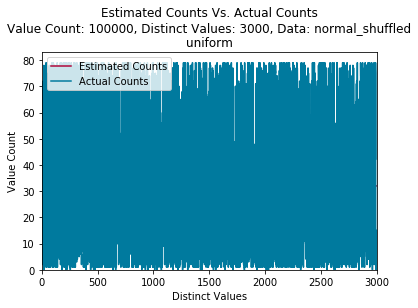

max error: 47
max relative error: 3100.0%
Estimation Technique: uniform
Sample Size: 3000
Mean Error: 24.8656666667
Mean Squared Error: 775.522333333
Column Size [kB](uint16_t): 200.0



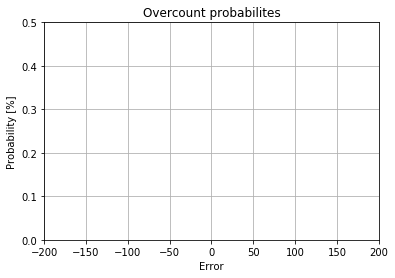

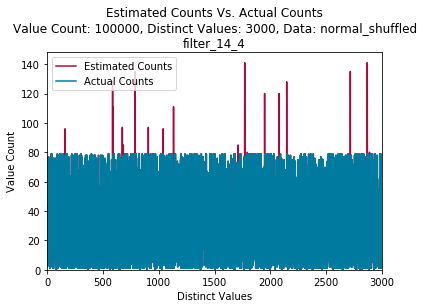

max error: 79
max relative error: 7900.0%
Estimation Technique: filter_14_4
Sample Size: 3000000
Mean Error: 0.377215
Mean Squared Error: 21.485537
Column Size [kB](uint16_t): 200.0



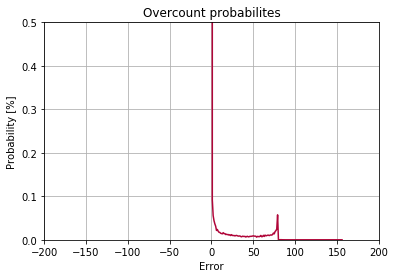

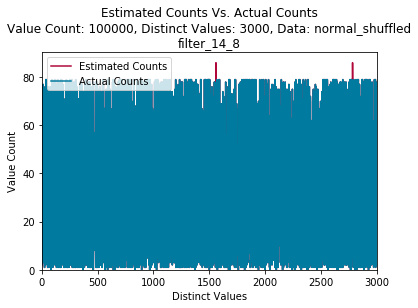

max error: 69
max relative error: 405.882352941%
Estimation Technique: filter_14_8
Sample Size: 3000000
Mean Error: 0.025324
Mean Squared Error: 1.43464466667
Column Size [kB](uint16_t): 200.0



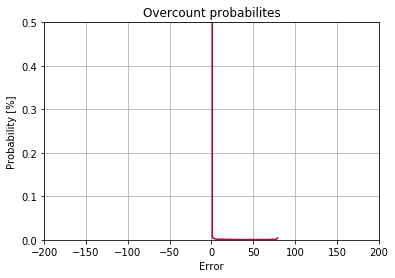

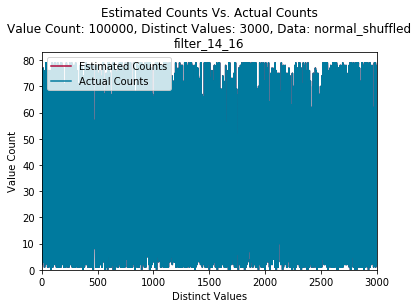

max error: 0
max relative error: 0%
Estimation Technique: filter_14_16
Sample Size: 3000000
Mean Error: 0.000214666666667
Mean Squared Error: 0.0149786666667
Column Size [kB](uint16_t): 200.0



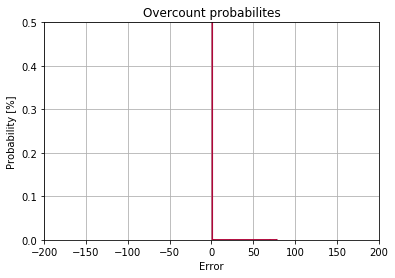

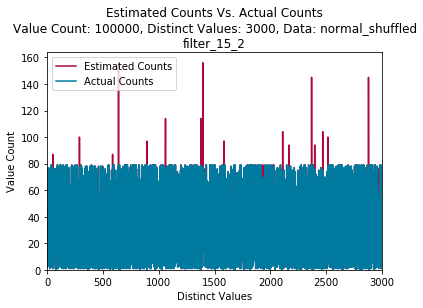

max error: 79
max relative error: 6800.0%
Estimation Technique: filter_15_2
Sample Size: 3000000
Mean Error: 0.751808333333
Mean Squared Error: 42.8955476667
Column Size [kB](uint16_t): 200.0



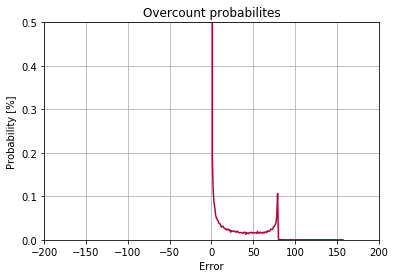

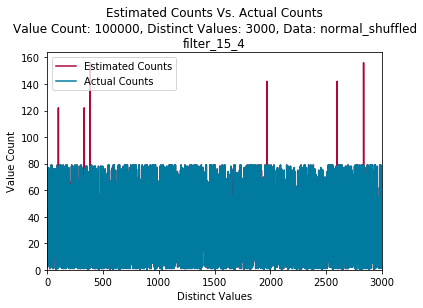

max error: 78
max relative error: 3200.0%
Estimation Technique: filter_15_4
Sample Size: 3000000
Mean Error: 0.188442666667
Mean Squared Error: 10.8104213333
Column Size [kB](uint16_t): 200.0



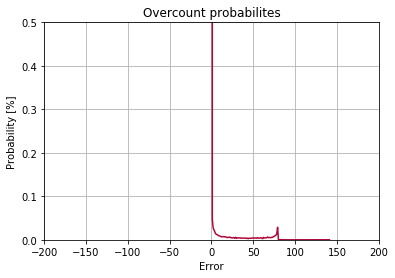

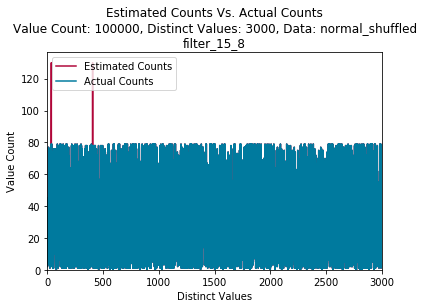

max error: 76
max relative error: 140.740740741%
Estimation Technique: filter_15_8
Sample Size: 3000000
Mean Error: 0.0124003333333
Mean Squared Error: 0.712565
Column Size [kB](uint16_t): 200.0



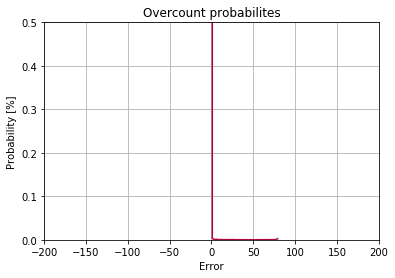

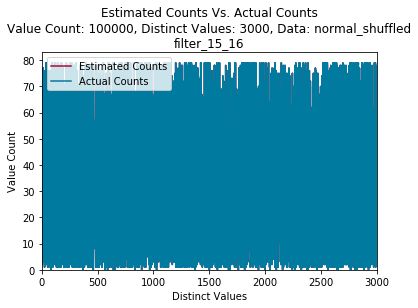

max error: 0
max relative error: 0%
Estimation Technique: filter_15_16
Sample Size: 3000000
Mean Error: 0.000165333333333
Mean Squared Error: 0.0113173333333
Column Size [kB](uint16_t): 200.0



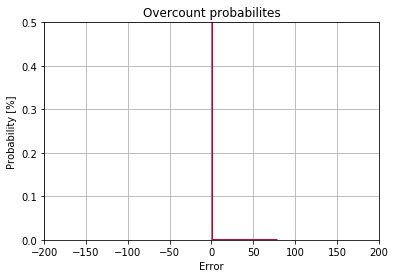

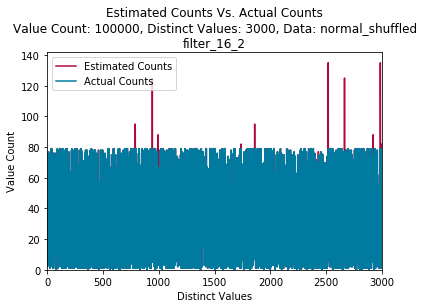

max error: 79
max relative error: 3700.0%
Estimation Technique: filter_16_2
Sample Size: 3000000
Mean Error: 0.372522333333
Mean Squared Error: 21.1130643333
Column Size [kB](uint16_t): 200.0



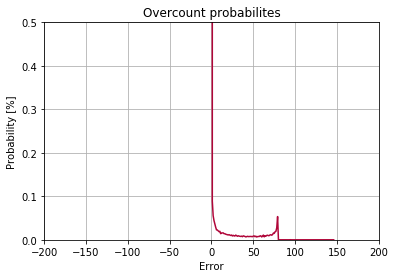

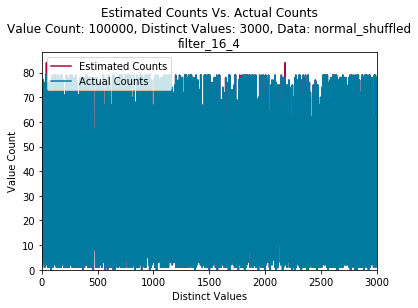

max error: 78
max relative error: 3850.0%
Estimation Technique: filter_16_4
Sample Size: 3000000
Mean Error: 0.0912816666667
Mean Squared Error: 5.18757233333
Column Size [kB](uint16_t): 200.0



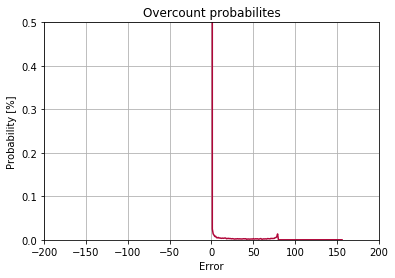

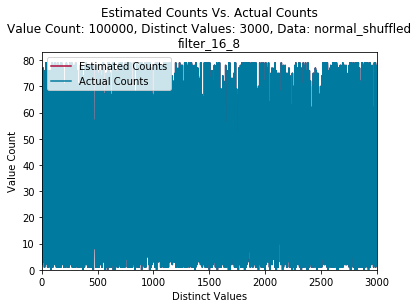

max error: 0
max relative error: 0%
Estimation Technique: filter_16_8
Sample Size: 3000000
Mean Error: 0.006012
Mean Squared Error: 0.344480666667
Column Size [kB](uint16_t): 200.0



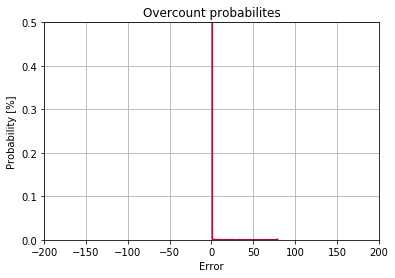

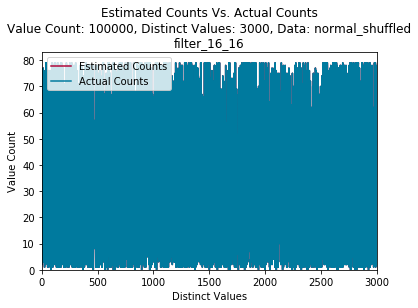

max error: 0
max relative error: 0%
Estimation Technique: filter_16_16
Sample Size: 3000000
Mean Error: 0.000107333333333
Mean Squared Error: 0.00748933333333
Column Size [kB](uint16_t): 200.0



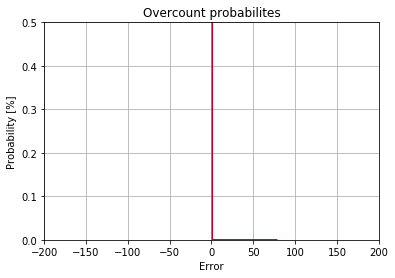

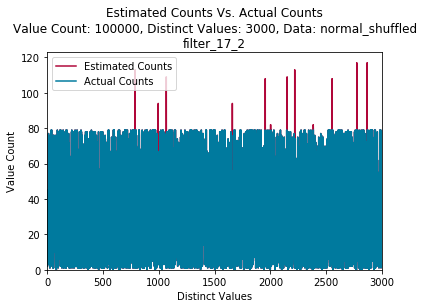

max error: 79
max relative error: 2633.33333333%
Estimation Technique: filter_17_2
Sample Size: 3000000
Mean Error: 0.183888333333
Mean Squared Error: 10.4682883333
Column Size [kB](uint16_t): 200.0



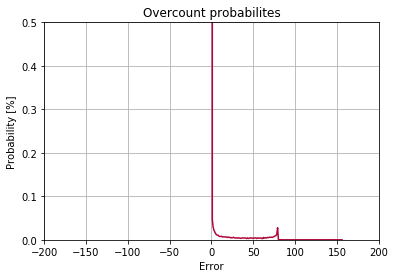

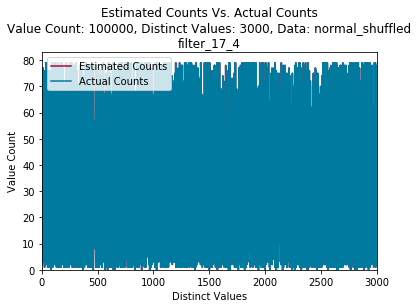

max error: 4
max relative error: 200.0%
Estimation Technique: filter_17_4
Sample Size: 3000000
Mean Error: 0.0491043333333
Mean Squared Error: 2.78926966667
Column Size [kB](uint16_t): 200.0



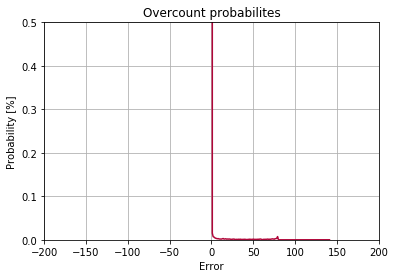

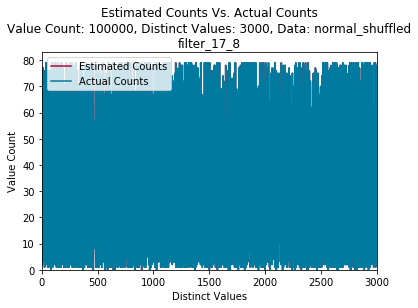

max error: 7
max relative error: 175.0%
Estimation Technique: filter_17_8
Sample Size: 3000000
Mean Error: 0.002846
Mean Squared Error: 0.157857333333
Column Size [kB](uint16_t): 200.0



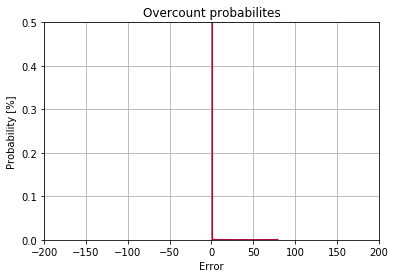

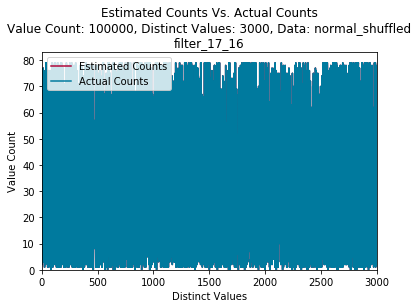

max error: 0
max relative error: 0%
Estimation Technique: filter_17_16
Sample Size: 3000000
Mean Error: 7.53333333333e-05
Mean Squared Error: 0.00416133333333
Column Size [kB](uint16_t): 200.0



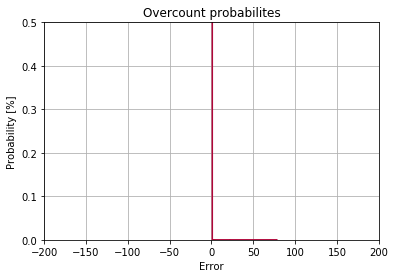

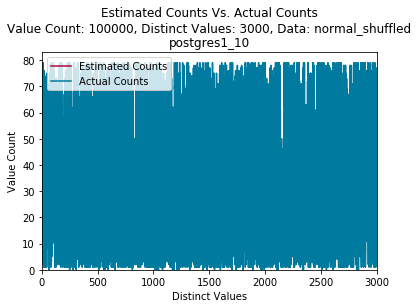

max error: 50
max relative error: 3400.0%
Estimation Technique: postgres1_10
Sample Size: 3000
Mean Error: 24.8466666667
Mean Squared Error: 773.792666667
Column Size [kB](uint16_t): 200.0



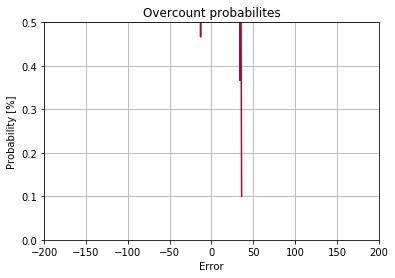

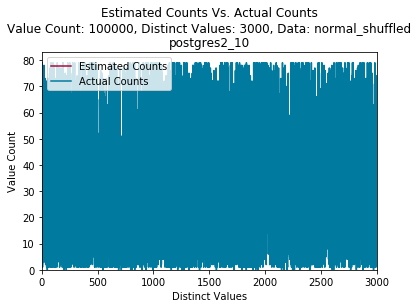

max error: 47
max relative error: 3100.0%
Estimation Technique: postgres2_10
Sample Size: 3000
Mean Error: 24.709
Mean Squared Error: 768.159
Column Size [kB](uint16_t): 200.0



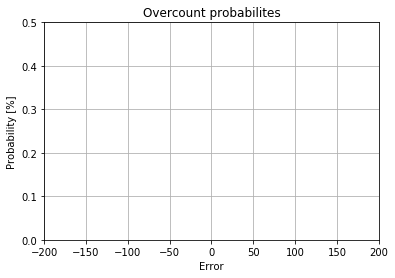

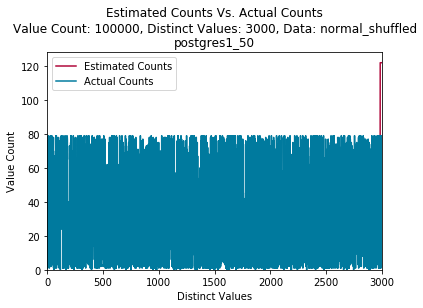

max error: 121
max relative error: 12100.0%
Estimation Technique: postgres1_50
Sample Size: 3000
Mean Error: 24.8396666667
Mean Squared Error: 795.842333333
Column Size [kB](uint16_t): 200.0



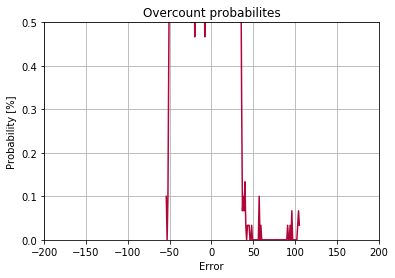

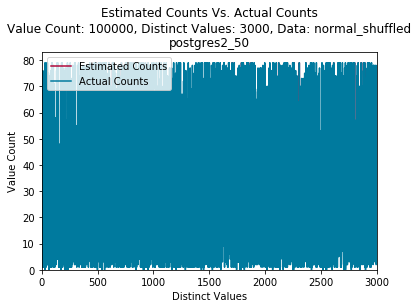

max error: 48
max relative error: 3000.0%
Estimation Technique: postgres2_50
Sample Size: 3000
Mean Error: 23.9663333333
Mean Squared Error: 739.608333333
Column Size [kB](uint16_t): 200.0



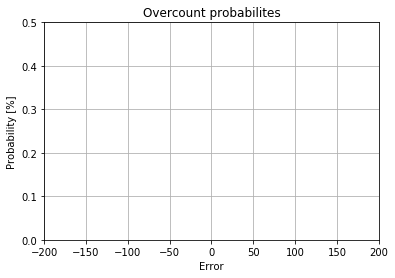

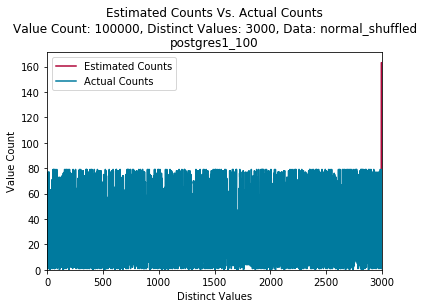

max error: 162
max relative error: 16200.0%
Estimation Technique: postgres1_100
Sample Size: 3000
Mean Error: 24.245
Mean Squared Error: 755.104333333
Column Size [kB](uint16_t): 200.0



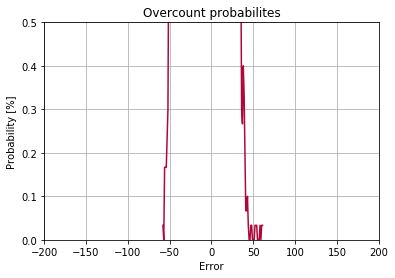

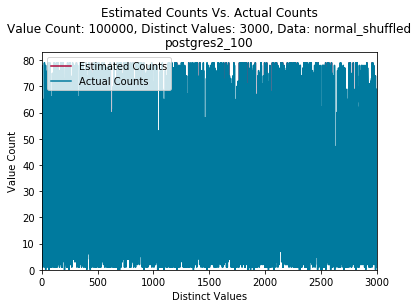

max error: 48
max relative error: 3000.0%
Estimation Technique: postgres2_100
Sample Size: 3000
Mean Error: 23.1663333333
Mean Squared Error: 701.208333333
Column Size [kB](uint16_t): 200.0



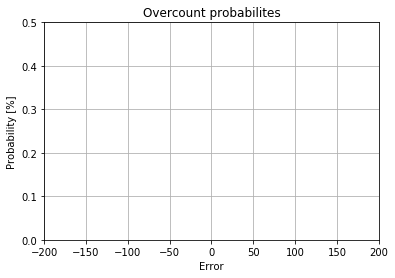

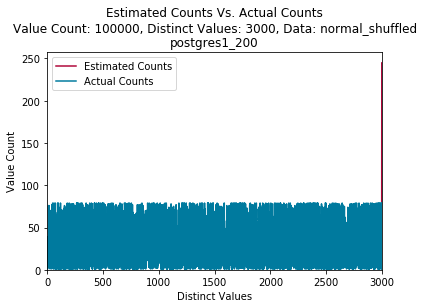

max error: 171
max relative error: 4300.0%
Estimation Technique: postgres1_200
Sample Size: 3000
Mean Error: 23.4
Mean Squared Error: 727.02
Column Size [kB](uint16_t): 200.0



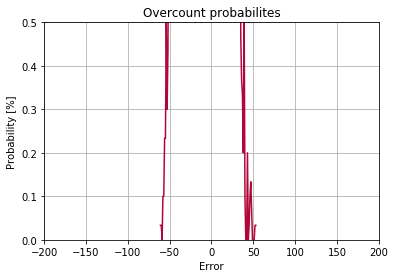

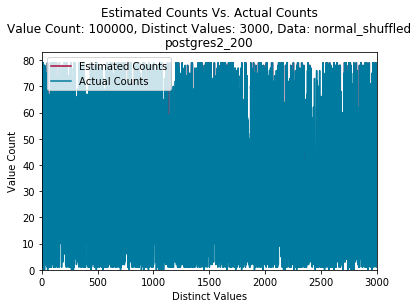

max error: 49
max relative error: 2800.0%
Estimation Technique: postgres2_200
Sample Size: 3000
Mean Error: 21.302
Mean Squared Error: 624.260666667
Column Size [kB](uint16_t): 200.0



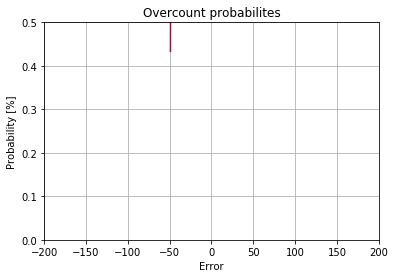

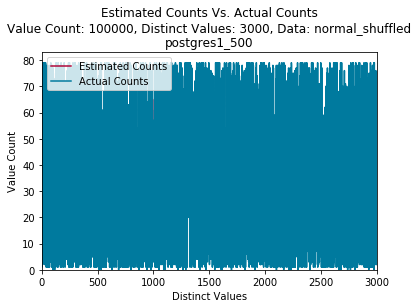

max error: 64
max relative error: 4800.0%
Estimation Technique: postgres1_500
Sample Size: 3000
Mean Error: 22.0976666667
Mean Squared Error: 684.512333333
Column Size [kB](uint16_t): 200.0



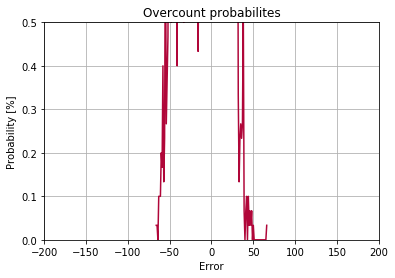

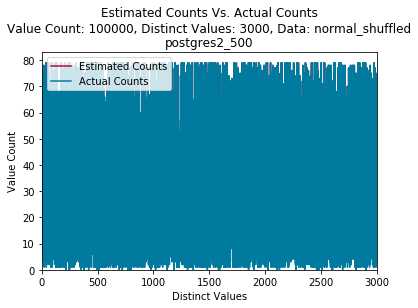

max error: 46
max relative error: 2300.0%
Estimation Technique: postgres2_500
Sample Size: 3000
Mean Error: 15.848
Mean Squared Error: 398.416666667
Column Size [kB](uint16_t): 200.0



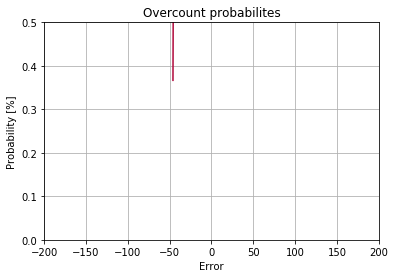

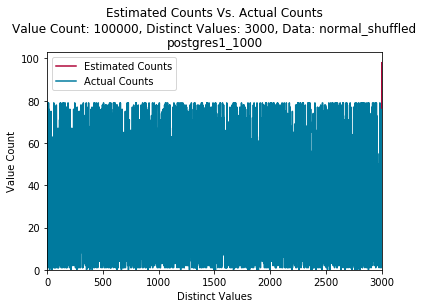

max error: 96
max relative error: 4800.0%
Estimation Technique: postgres1_1000
Sample Size: 3000
Mean Error: 21.1486666667
Mean Squared Error: 679.643333333
Column Size [kB](uint16_t): 200.0



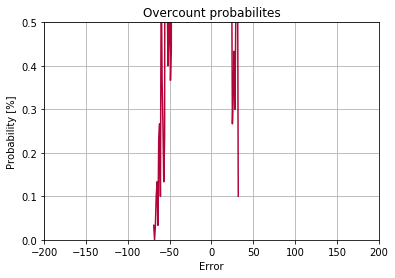

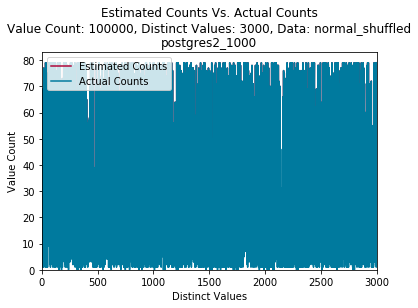

max error: 33
max relative error: 1400.0%
Estimation Technique: postgres2_1000
Sample Size: 3000
Mean Error: 7.93933333333
Mean Squared Error: 130.826666667
Column Size [kB](uint16_t): 200.0



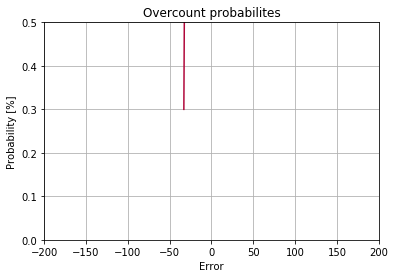

Estimation Technique  Memory Consumption  Mean Error  Mean Squared Error
0               uniform                 1.0   33.858333         8194.794333
1          postgres1_10                40.0    4.590667          247.644667
2          postgres1_50               200.0    2.625000          358.069667
3         postgres1_100               400.0    3.609000          568.384333
4          postgres2_10                40.0   28.356667         4099.660667
5          postgres2_50               200.0   19.026667         1167.632667
6         postgres2_100               400.0   13.921000          530.070333
7           filter_14_4             12288.0    0.382915          109.469391
8           filter_14_8             20480.0    0.028436            7.971946
9          filter_14_16             36864.0    0.000078            0.003468
10          filter_15_2             16384.0    0.747989          208.416308
11          filter_15_4             24576.0    0.190194           54.903948
12          filter_15_8             40960.0    0.013214            4.137235
13         filter_15_16             73728.0    0.000059            0.002370
14          filter_16_2             32768.0    0.373439          102.053003
15          filter_16_4             49152.0    0.096454           25.449393
16          filter_16_8             81920.0    0.008744            3.408725
17         filter_16_16            147456.0    0.000054            0.002327

Estimation Technique  Memory Consumption  Mean Error  Mean Squared Error
0           filter_14_4             12288.0    0.382915          109.469391
1           filter_14_8             20480.0    0.028436            7.971946
2          filter_14_16             36864.0    0.000078            0.003468
3           filter_15_2             16384.0    0.747989          208.416308
4           filter_15_4             24576.0    0.190194           54.903948
5           filter_15_8             40960.0    0.013214            4.137235
6          filter_15_16             73728.0    0.000059            0.002370
7           filter_16_2             32768.0    0.373439          102.053003
8           filter_16_4             49152.0    0.096454           25.449393
9           filter_16_8             81920.0    0.008744            3.408725
10         filter_16_16            147456.0    0.000054            0.002327

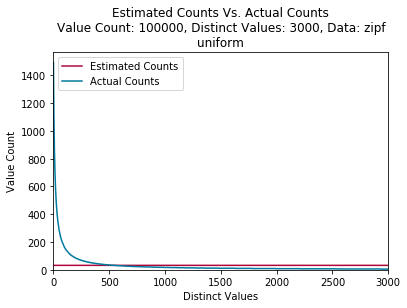

max error: 1459
max relative error: 540.0%
Estimation Technique: uniform
Sample Size: 3000
Mean Error: 33.8583333333
Mean Squared Error: 8194.79433333
Column Size [kB](uint16_t): 200.0



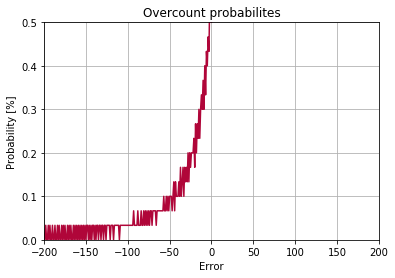

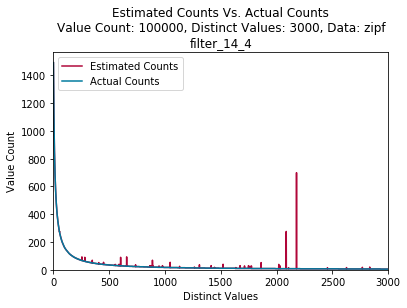

max error: 691
max relative error: 8637.5%
Estimation Technique: filter_14_4
Sample Size: 3000000
Mean Error: 0.382914666667
Mean Squared Error: 109.469391333
Column Size [kB](uint16_t): 200.0



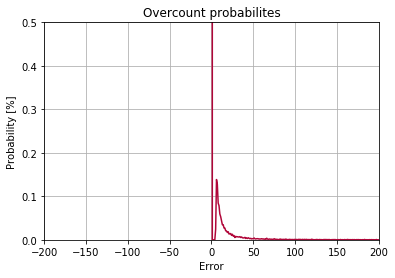

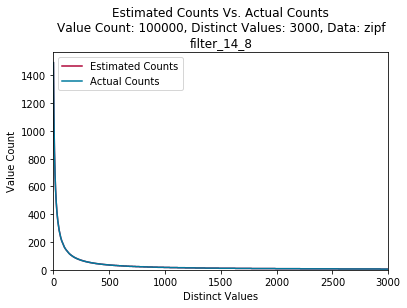

max error: 0
max relative error: 0%
Estimation Technique: filter_14_8
Sample Size: 3000000
Mean Error: 0.0284356666667
Mean Squared Error: 7.97194633333
Column Size [kB](uint16_t): 200.0



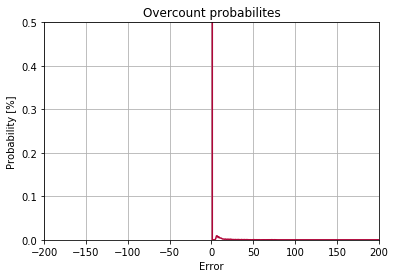

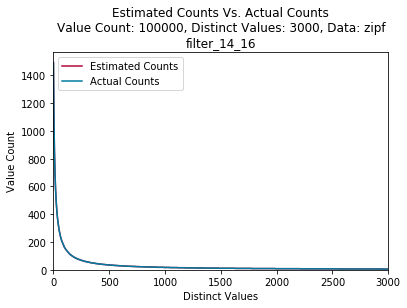

max error: 0
max relative error: 0%
Estimation Technique: filter_14_16
Sample Size: 3000000
Mean Error: 7.83333333333e-05
Mean Squared Error: 0.00346833333333
Column Size [kB](uint16_t): 200.0



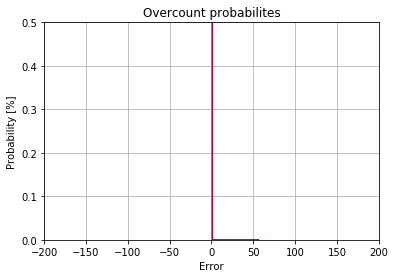

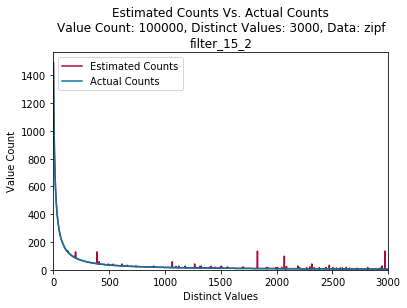

max error: 130
max relative error: 2600.0%
Estimation Technique: filter_15_2
Sample Size: 3000000
Mean Error: 0.747988666667
Mean Squared Error: 208.416308
Column Size [kB](uint16_t): 200.0



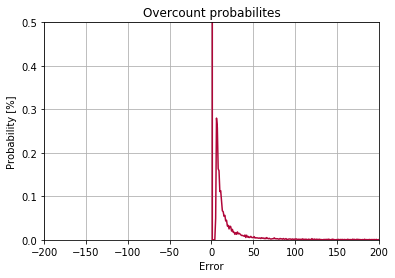

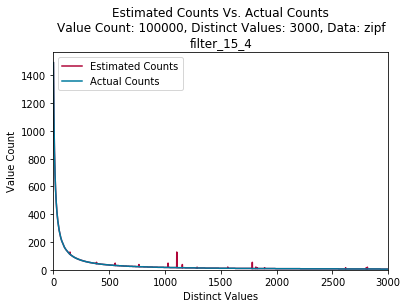

max error: 112
max relative error: 700.0%
Estimation Technique: filter_15_4
Sample Size: 3000000
Mean Error: 0.190194333333
Mean Squared Error: 54.9039483333
Column Size [kB](uint16_t): 200.0



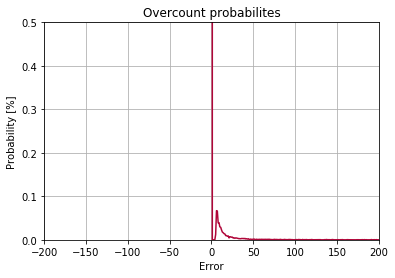

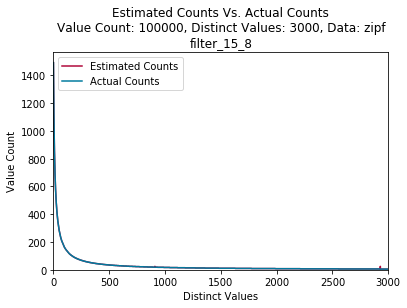

max error: 19
max relative error: 316.666666667%
Estimation Technique: filter_15_8
Sample Size: 3000000
Mean Error: 0.0132143333333
Mean Squared Error: 4.137235
Column Size [kB](uint16_t): 200.0



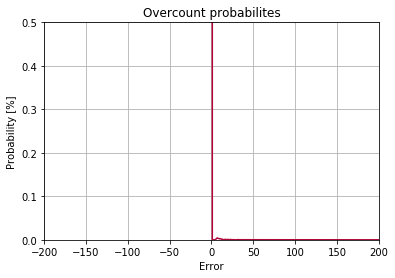

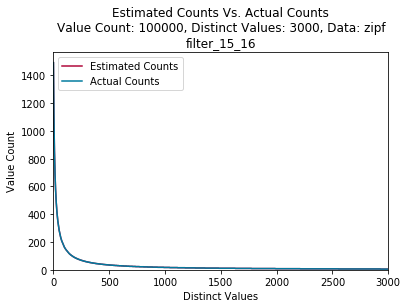

max error: 0
max relative error: 0%
Estimation Technique: filter_15_16
Sample Size: 3000000
Mean Error: 5.93333333333e-05
Mean Squared Error: 0.00237
Column Size [kB](uint16_t): 200.0



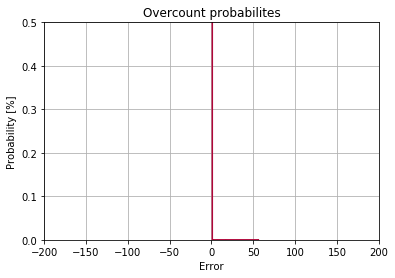

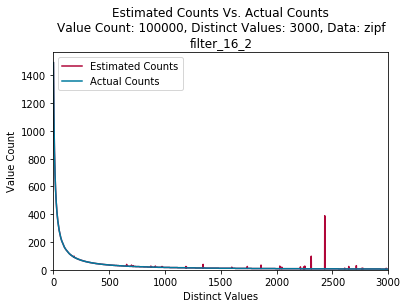

max error: 382
max relative error: 5457.14285714%
Estimation Technique: filter_16_2
Sample Size: 3000000
Mean Error: 0.373439333333
Mean Squared Error: 102.053002667
Column Size [kB](uint16_t): 200.0



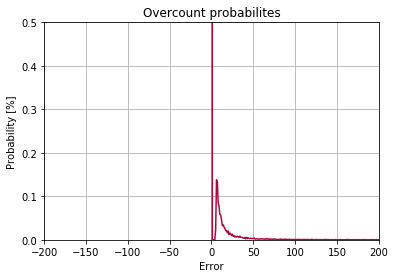

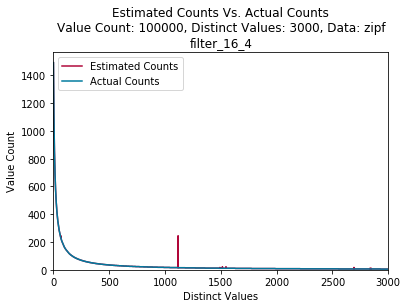

max error: 230
max relative error: 1533.33333333%
Estimation Technique: filter_16_4
Sample Size: 3000000
Mean Error: 0.0964543333333
Mean Squared Error: 25.449393
Column Size [kB](uint16_t): 200.0



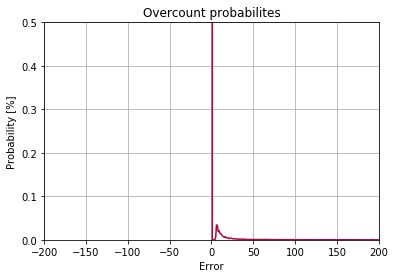

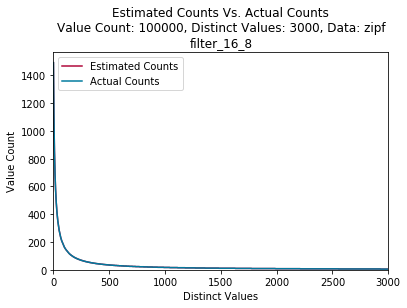

max error: 0
max relative error: 0%
Estimation Technique: filter_16_8
Sample Size: 3000000
Mean Error: 0.00874433333333
Mean Squared Error: 3.408725
Column Size [kB](uint16_t): 200.0



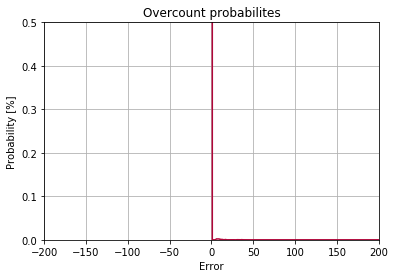

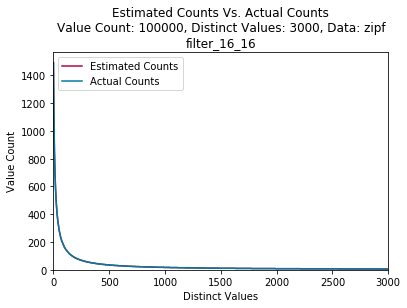

max error: 0
max relative error: 0%
Estimation Technique: filter_16_16
Sample Size: 3000000
Mean Error: 5.4e-05
Mean Squared Error: 0.00232666666667
Column Size [kB](uint16_t): 200.0



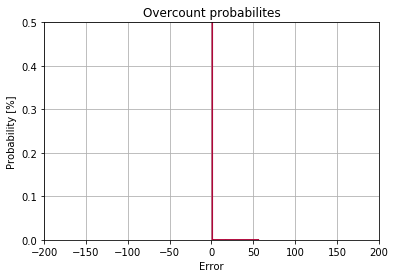

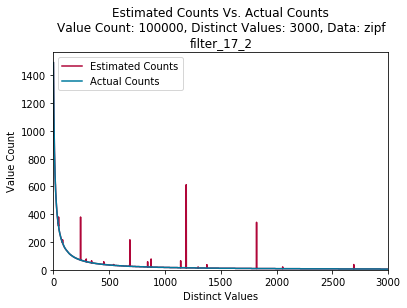

max error: 599
max relative error: 4278.57142857%
Estimation Technique: filter_17_2
Sample Size: 3000000
Mean Error: 0.183980666667
Mean Squared Error: 48.35694
Column Size [kB](uint16_t): 200.0



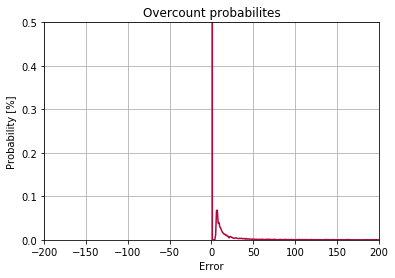

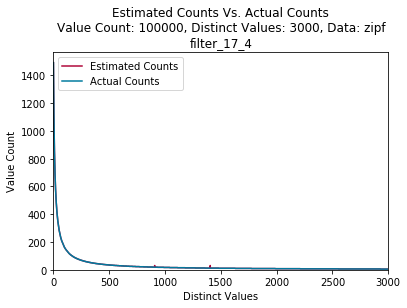

max error: 19
max relative error: 158.333333333%
Estimation Technique: filter_17_4
Sample Size: 3000000
Mean Error: 0.0497903333333
Mean Squared Error: 14.1729676667
Column Size [kB](uint16_t): 200.0



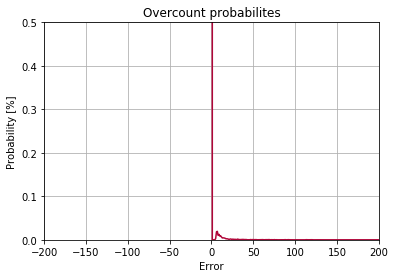

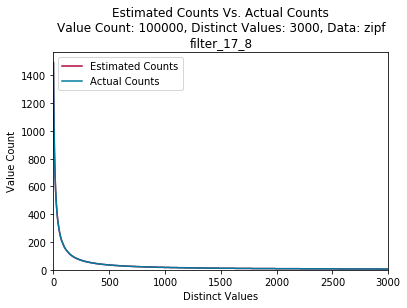

max error: 0
max relative error: 0%
Estimation Technique: filter_17_8
Sample Size: 3000000
Mean Error: 0.00407866666667
Mean Squared Error: 1.347136
Column Size [kB](uint16_t): 200.0



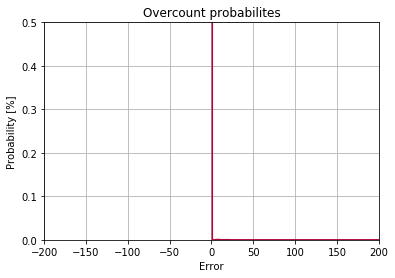

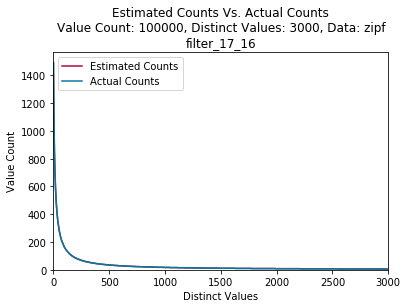

max error: 0
max relative error: 0%
Estimation Technique: filter_17_16
Sample Size: 3000000
Mean Error: 5.4e-05
Mean Squared Error: 0.00232666666667
Column Size [kB](uint16_t): 200.0



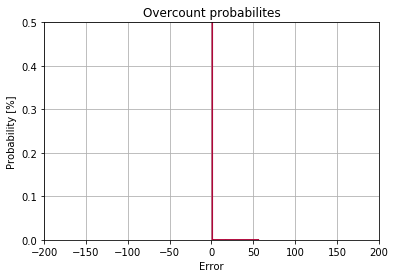

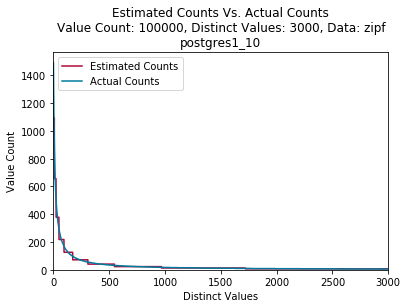

max error: 397
max relative error: 40.0%
Estimation Technique: postgres1_10
Sample Size: 3000
Mean Error: 4.59066666667
Mean Squared Error: 247.644666667
Column Size [kB](uint16_t): 200.0



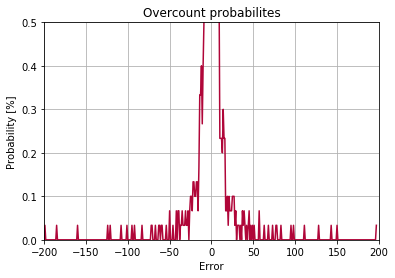

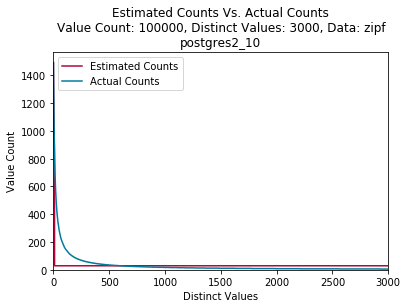

max error: 787
max relative error: 480.0%
Estimation Technique: postgres2_10
Sample Size: 3000
Mean Error: 28.3566666667
Mean Squared Error: 4099.66066667
Column Size [kB](uint16_t): 200.0



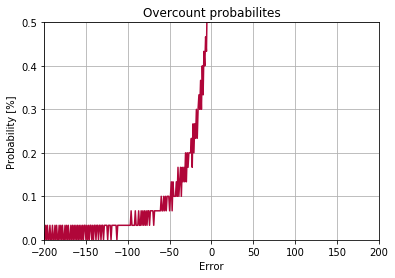

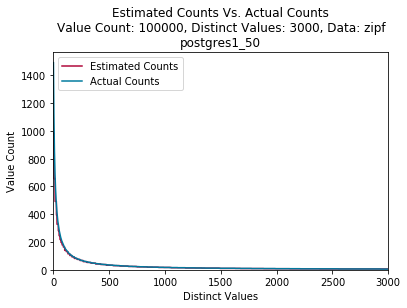

max error: 506
max relative error: 34.1365461847%
Estimation Technique: postgres1_50
Sample Size: 3000
Mean Error: 2.625
Mean Squared Error: 358.069666667
Column Size [kB](uint16_t): 200.0



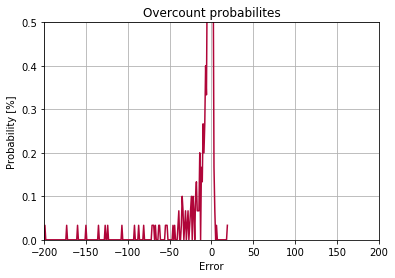

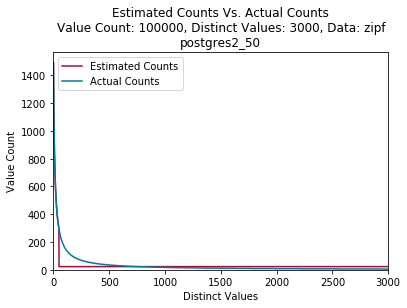

max error: 267
max relative error: 360.0%
Estimation Technique: postgres2_50
Sample Size: 3000
Mean Error: 19.0266666667
Mean Squared Error: 1167.63266667
Column Size [kB](uint16_t): 200.0



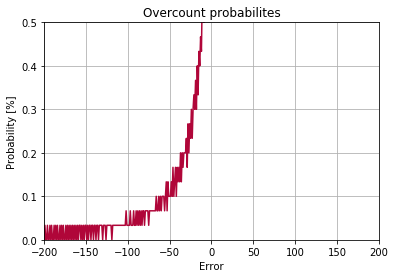

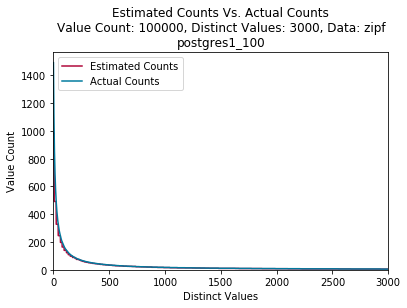

max error: 506
max relative error: 47.8813559322%
Estimation Technique: postgres1_100
Sample Size: 3000
Mean Error: 3.609
Mean Squared Error: 568.384333333
Column Size [kB](uint16_t): 200.0



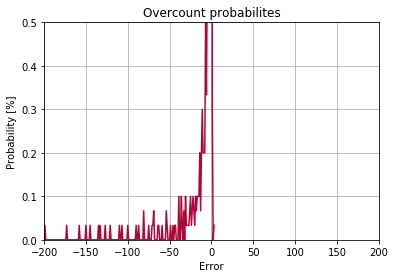

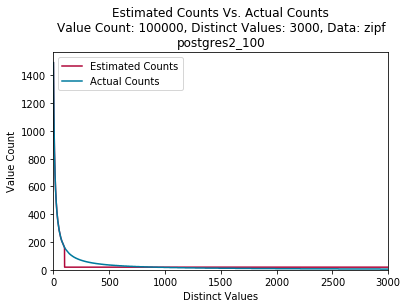

max error: 141
max relative error: 280.0%
Estimation Technique: postgres2_100
Sample Size: 3000
Mean Error: 13.921
Mean Squared Error: 530.070333333
Column Size [kB](uint16_t): 200.0



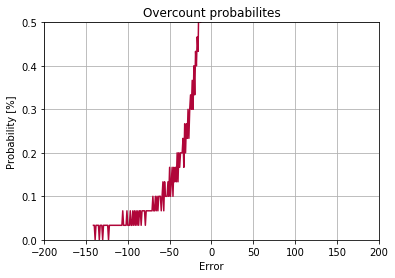

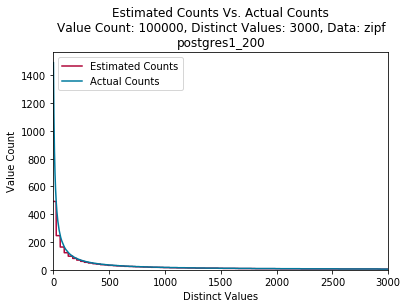

max error: 999
max relative error: 67.0020120724%
Estimation Technique: postgres1_200
Sample Size: 3000
Mean Error: 5.82766666667
Mean Squared Error: 1803.72766667
Column Size [kB](uint16_t): 200.0



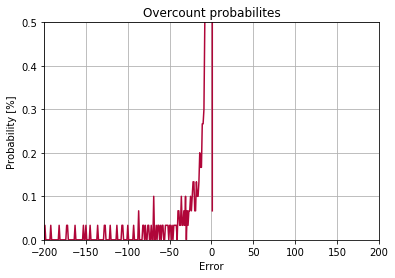

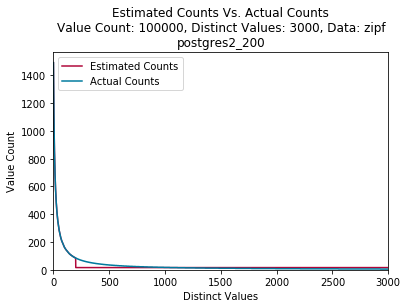

max error: 68
max relative error: 220.0%
Estimation Technique: postgres2_200
Sample Size: 3000
Mean Error: 9.50233333333
Mean Squared Error: 203.437666667
Column Size [kB](uint16_t): 200.0



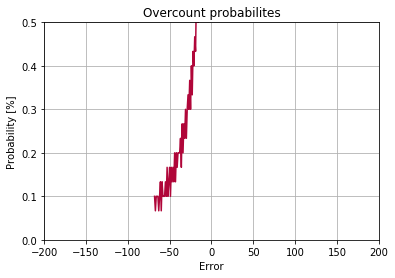

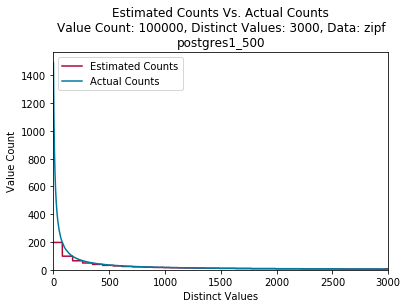

max error: 1294
max relative error: 86.7873910127%
Estimation Technique: postgres1_500
Sample Size: 3000
Mean Error: 10.1666666667
Mean Squared Error: 4376.00933333
Column Size [kB](uint16_t): 200.0



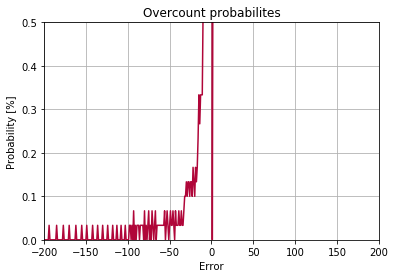

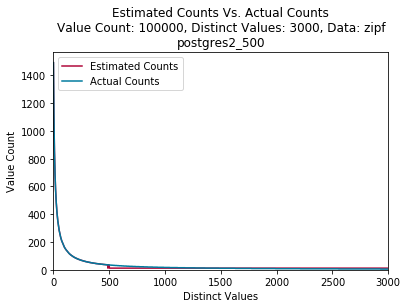

max error: 23
max relative error: 140.0%
Estimation Technique: postgres2_500
Sample Size: 3000
Mean Error: 4.467
Mean Squared Error: 39.6796666667
Column Size [kB](uint16_t): 200.0



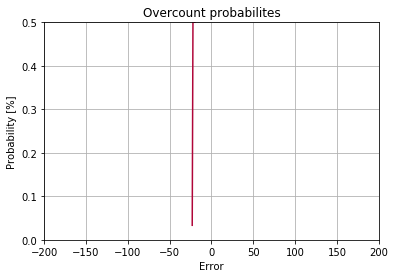

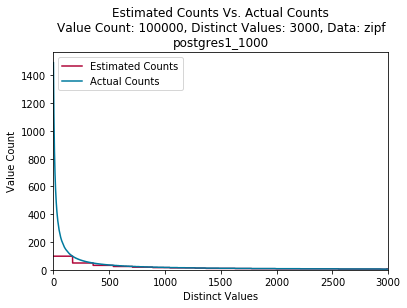

max error: 1393
max relative error: 93.4272300469%
Estimation Technique: postgres1_1000
Sample Size: 3000
Mean Error: 13.5903333333
Mean Squared Error: 6080.01833333
Column Size [kB](uint16_t): 200.0



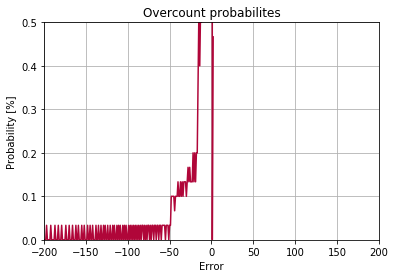

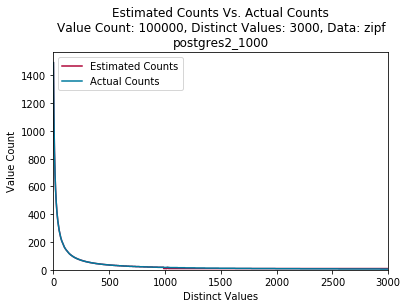

max error: 8
max relative error: 80.0%
Estimation Technique: postgres2_1000
Sample Size: 3000
Mean Error: 1.72033333333
Mean Squared Error: 6.71433333333
Column Size [kB](uint16_t): 200.0



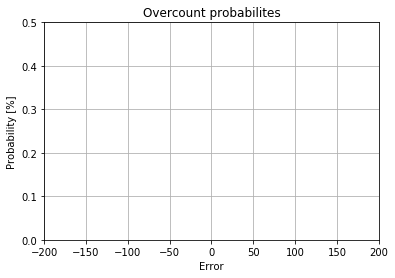

Estimation Technique  Memory Consumption  Mean Error  Mean Squared Error
0               uniform                 1.0   33.858333         8194.794333
1          postgres1_10                40.0   34.080333         8169.018333
2          postgres1_50               200.0   32.965333         8112.737333
3         postgres1_100               400.0   31.612333         8000.259000
4          postgres2_10                40.0   28.356667         4099.660667
5          postgres2_50               200.0   19.026667         1167.632667
6         postgres2_100               400.0   13.921000          530.070333
7           filter_14_4             12288.0    0.381450          106.726542
8           filter_14_8             20480.0    0.033072           13.858326
9          filter_14_16             36864.0    0.000171            0.006045
10          filter_15_2             16384.0    0.747042          215.069027
11          filter_15_4             24576.0    0.190001           54.776070
12          filter_15_8             40960.0    0.017474           10.476465
13         filter_15_16             73728.0    0.000076            0.002220
14          filter_16_2             32768.0    0.367611           98.294444
15          filter_16_4             49152.0    0.100940           31.734216
16          filter_16_8             81920.0    0.006123            2.288474
17         filter_16_16            147456.0    0.000057            0.002015

Estimation Technique  Memory Consumption  Mean Error  Mean Squared Error
0           filter_14_4             12288.0    0.381450          106.726542
1           filter_14_8             20480.0    0.033072           13.858326
2          filter_14_16             36864.0    0.000171            0.006045
3           filter_15_2             16384.0    0.747042          215.069027
4           filter_15_4             24576.0    0.190001           54.776070
5           filter_15_8             40960.0    0.017474           10.476465
6          filter_15_16             73728.0    0.000076            0.002220
7           filter_16_2             32768.0    0.367611           98.294444
8           filter_16_4             49152.0    0.100940           31.734216
9           filter_16_8             81920.0    0.006123            2.288474
10         filter_16_16            147456.0    0.000057            0.002015

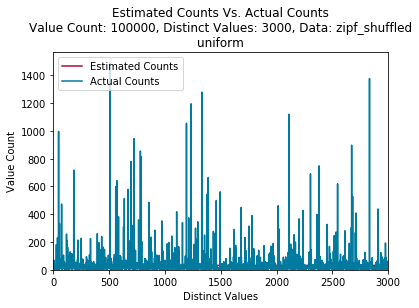

max error: 1459
max relative error: 540.0%
Estimation Technique: uniform
Sample Size: 3000
Mean Error: 33.8583333333
Mean Squared Error: 8194.79433333
Column Size [kB](uint16_t): 200.0



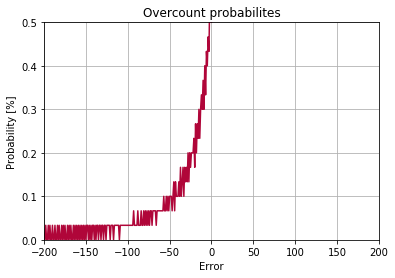

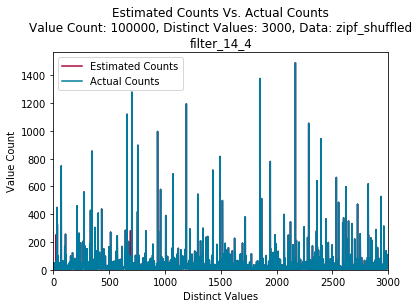

max error: 268
max relative error: 2430.0%
Estimation Technique: filter_14_4
Sample Size: 3000000
Mean Error: 0.381450333333
Mean Squared Error: 106.726542333
Column Size [kB](uint16_t): 200.0



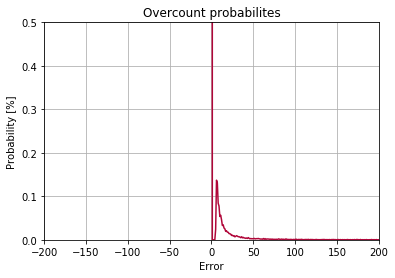

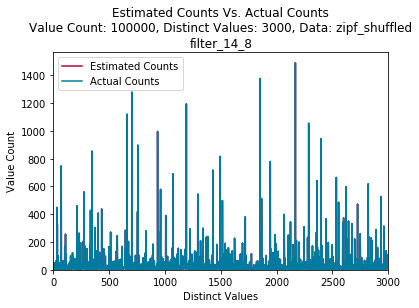

max error: 10
max relative error: 166.666666667%
Estimation Technique: filter_14_8
Sample Size: 3000000
Mean Error: 0.0330723333333
Mean Squared Error: 13.8583263333
Column Size [kB](uint16_t): 200.0



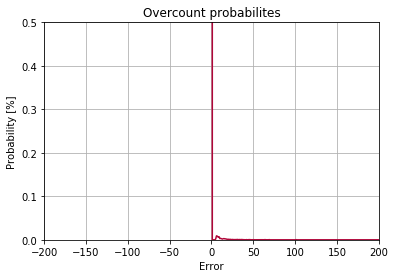

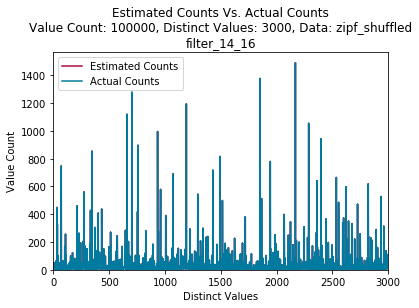

max error: 0
max relative error: 0%
Estimation Technique: filter_14_16
Sample Size: 3000000
Mean Error: 0.000171
Mean Squared Error: 0.006045
Column Size [kB](uint16_t): 200.0



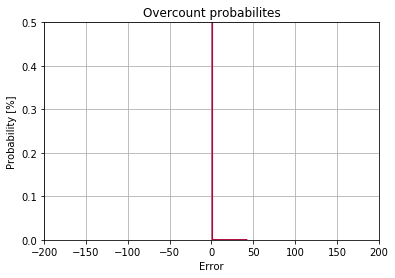

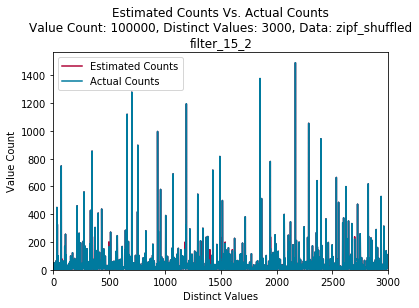

max error: 222
max relative error: 2122.22222222%
Estimation Technique: filter_15_2
Sample Size: 3000000
Mean Error: 0.747041666667
Mean Squared Error: 215.069027
Column Size [kB](uint16_t): 200.0



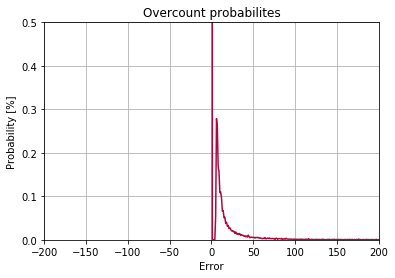

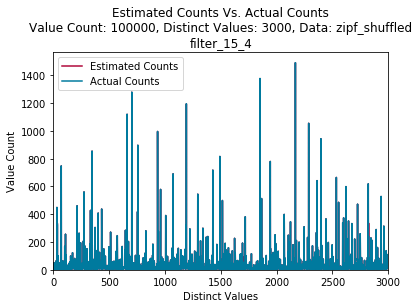

max error: 327
max relative error: 3633.33333333%
Estimation Technique: filter_15_4
Sample Size: 3000000
Mean Error: 0.190000666667
Mean Squared Error: 54.77607
Column Size [kB](uint16_t): 200.0



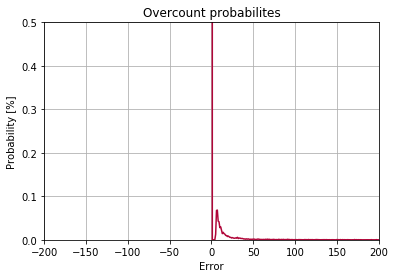

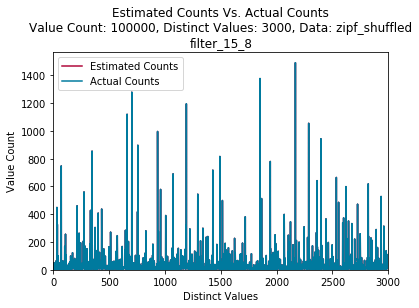

max error: 16
max relative error: 200.0%
Estimation Technique: filter_15_8
Sample Size: 3000000
Mean Error: 0.0174743333333
Mean Squared Error: 10.476465
Column Size [kB](uint16_t): 200.0



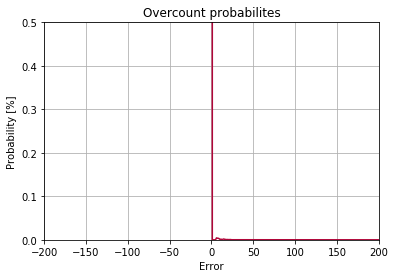

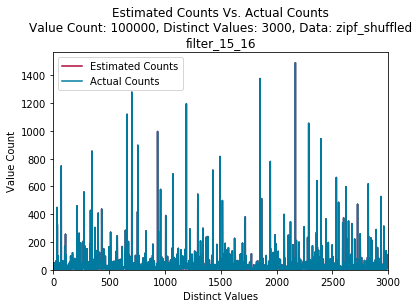

max error: 0
max relative error: 0%
Estimation Technique: filter_15_16
Sample Size: 3000000
Mean Error: 7.6e-05
Mean Squared Error: 0.00222
Column Size [kB](uint16_t): 200.0



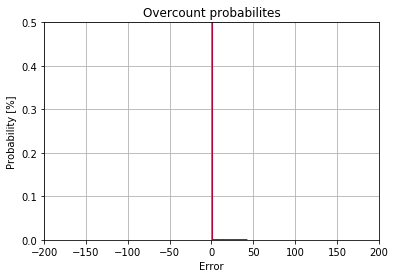

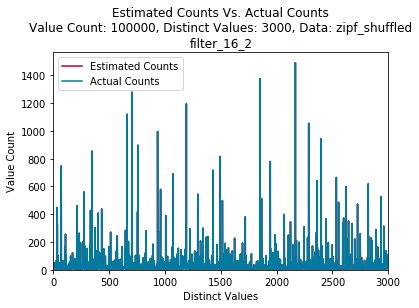

max error: 157
max relative error: 1962.5%
Estimation Technique: filter_16_2
Sample Size: 3000000
Mean Error: 0.367610666667
Mean Squared Error: 98.294444
Column Size [kB](uint16_t): 200.0



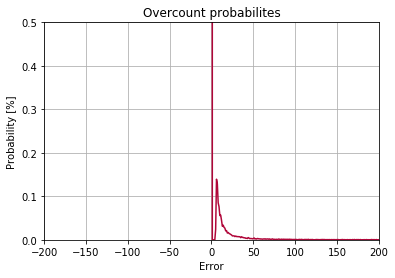

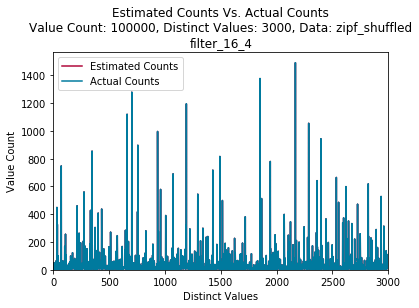

max error: 13
max relative error: 216.666666667%
Estimation Technique: filter_16_4
Sample Size: 3000000
Mean Error: 0.10094
Mean Squared Error: 31.734216
Column Size [kB](uint16_t): 200.0



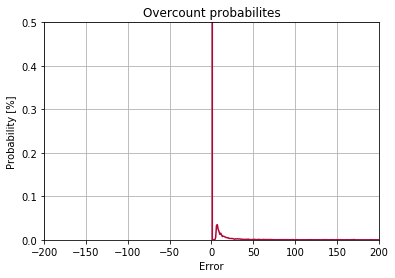

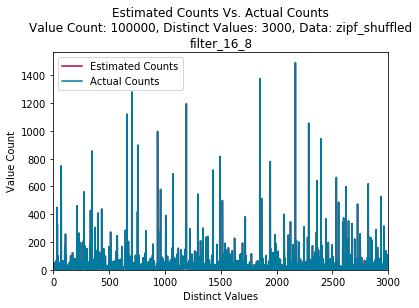

max error: 0
max relative error: 0%
Estimation Technique: filter_16_8
Sample Size: 3000000
Mean Error: 0.006123
Mean Squared Error: 2.28847433333
Column Size [kB](uint16_t): 200.0



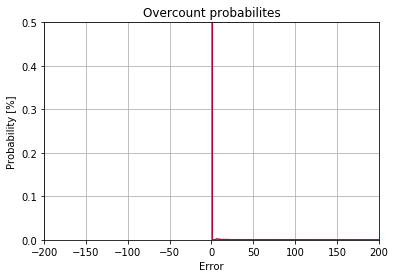

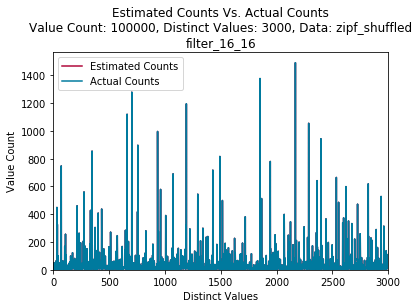

max error: 0
max relative error: 0%
Estimation Technique: filter_16_16
Sample Size: 3000000
Mean Error: 5.7e-05
Mean Squared Error: 0.002015
Column Size [kB](uint16_t): 200.0



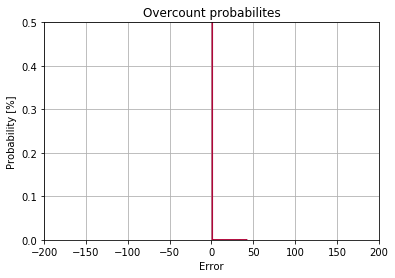

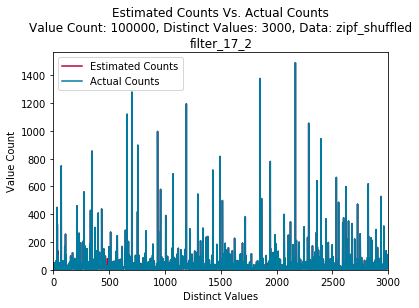

max error: 130
max relative error: 1857.14285714%
Estimation Technique: filter_17_2
Sample Size: 3000000
Mean Error: 0.19306
Mean Squared Error: 59.205974
Column Size [kB](uint16_t): 200.0



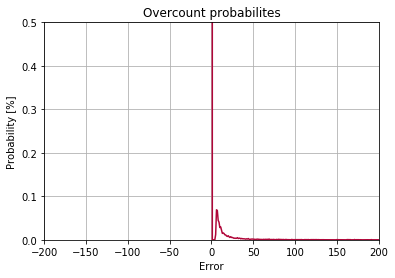

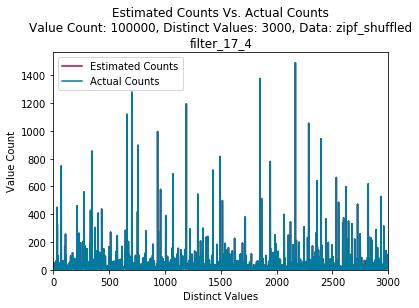

max error: 47
max relative error: 340.0%
Estimation Technique: filter_17_4
Sample Size: 3000000
Mean Error: 0.059881
Mean Squared Error: 22.9500043333
Column Size [kB](uint16_t): 200.0



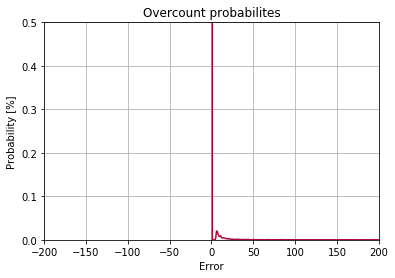

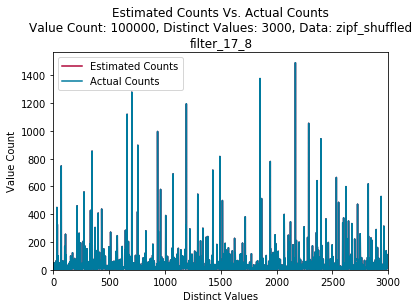

max error: 0
max relative error: 0%
Estimation Technique: filter_17_8
Sample Size: 3000000
Mean Error: 0.00212333333333
Mean Squared Error: 0.194924
Column Size [kB](uint16_t): 200.0



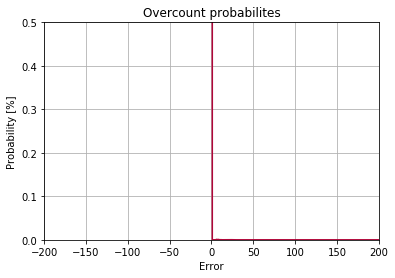

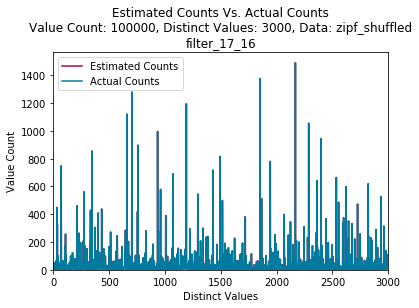

max error: 0
max relative error: 0%
Estimation Technique: filter_17_16
Sample Size: 3000000
Mean Error: 9.5e-05
Mean Squared Error: 0.003125
Column Size [kB](uint16_t): 200.0



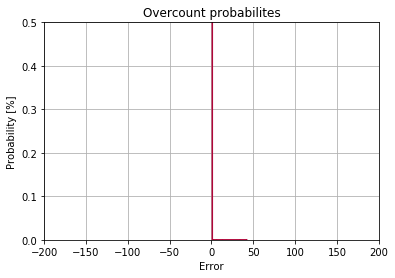

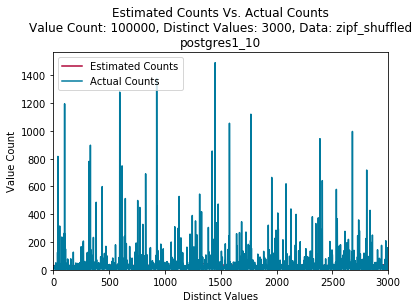

max error: 1447
max relative error: 780.0%
Estimation Technique: postgres1_10
Sample Size: 3000
Mean Error: 34.0803333333
Mean Squared Error: 8169.01833333
Column Size [kB](uint16_t): 200.0



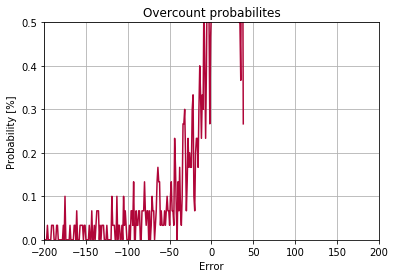

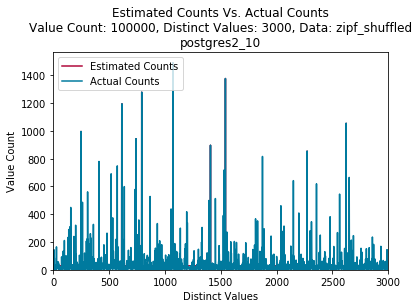

max error: 787
max relative error: 480.0%
Estimation Technique: postgres2_10
Sample Size: 3000
Mean Error: 28.3566666667
Mean Squared Error: 4099.66066667
Column Size [kB](uint16_t): 200.0



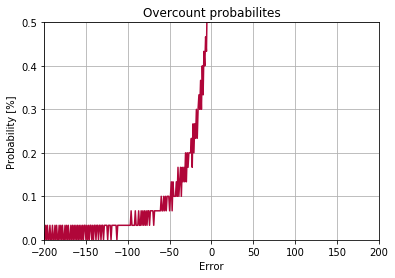

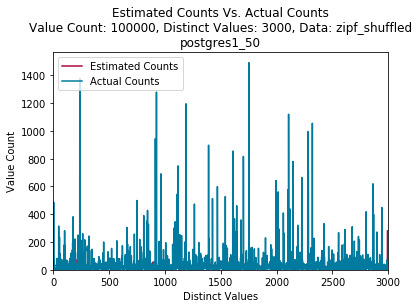

max error: 1451
max relative error: 3022.22222222%
Estimation Technique: postgres1_50
Sample Size: 3000
Mean Error: 32.9653333333
Mean Squared Error: 8112.73733333
Column Size [kB](uint16_t): 200.0



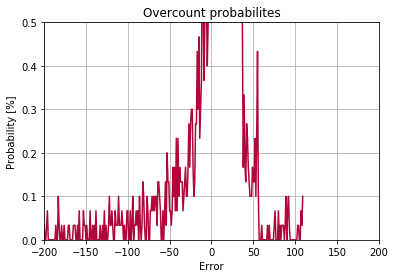

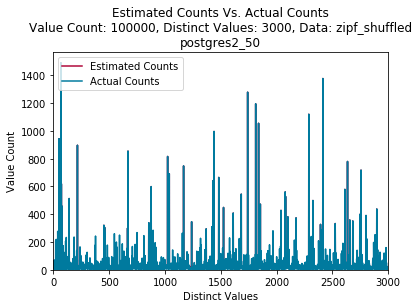

max error: 267
max relative error: 360.0%
Estimation Technique: postgres2_50
Sample Size: 3000
Mean Error: 19.0266666667
Mean Squared Error: 1167.63266667
Column Size [kB](uint16_t): 200.0



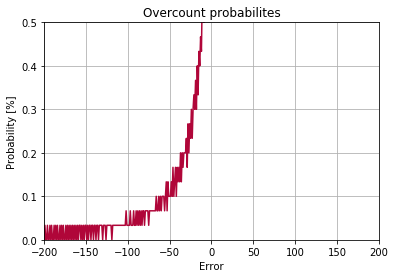

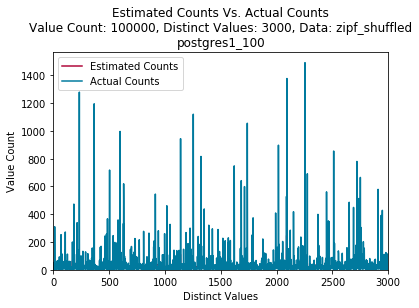

max error: 1421
max relative error: 3414.28571429%
Estimation Technique: postgres1_100
Sample Size: 3000
Mean Error: 31.6123333333
Mean Squared Error: 8000.259
Column Size [kB](uint16_t): 200.0



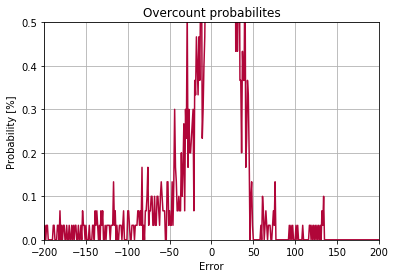

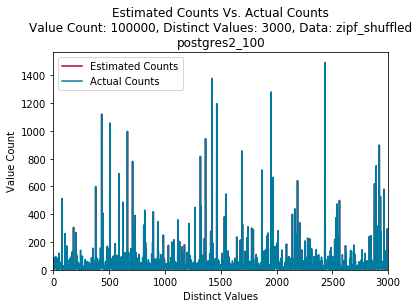

max error: 141
max relative error: 280.0%
Estimation Technique: postgres2_100
Sample Size: 3000
Mean Error: 13.921
Mean Squared Error: 530.070333333
Column Size [kB](uint16_t): 200.0



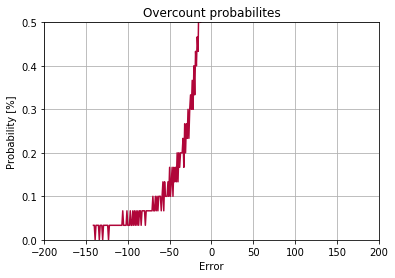

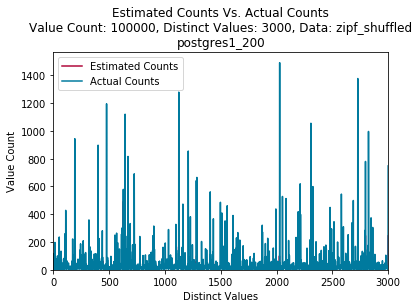

max error: 1393
max relative error: 4000.0%
Estimation Technique: postgres1_200
Sample Size: 3000
Mean Error: 29.1293333333
Mean Squared Error: 7920.13466667
Column Size [kB](uint16_t): 200.0



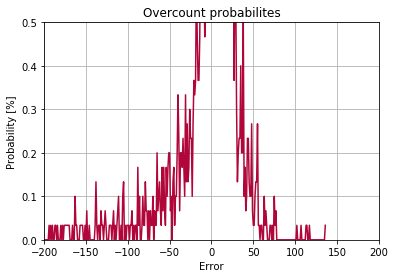

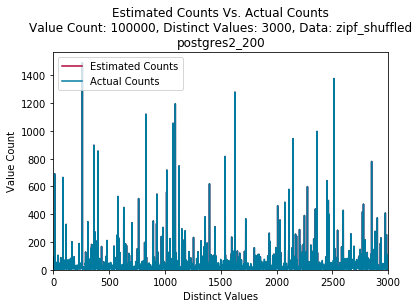

max error: 68
max relative error: 220.0%
Estimation Technique: postgres2_200
Sample Size: 3000
Mean Error: 9.50233333333
Mean Squared Error: 203.437666667
Column Size [kB](uint16_t): 200.0



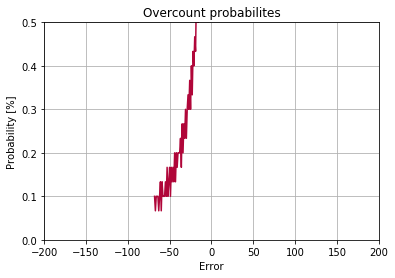

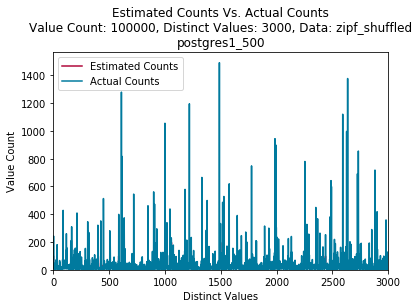

max error: 1472
max relative error: 1300.0%
Estimation Technique: postgres1_500
Sample Size: 3000
Mean Error: 26.1403333333
Mean Squared Error: 7643.671
Column Size [kB](uint16_t): 200.0



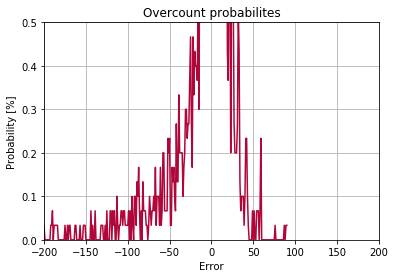

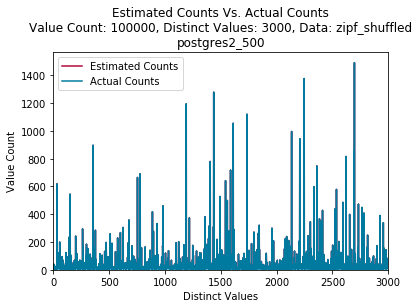

max error: 23
max relative error: 140.0%
Estimation Technique: postgres2_500
Sample Size: 3000
Mean Error: 4.467
Mean Squared Error: 39.6796666667
Column Size [kB](uint16_t): 200.0



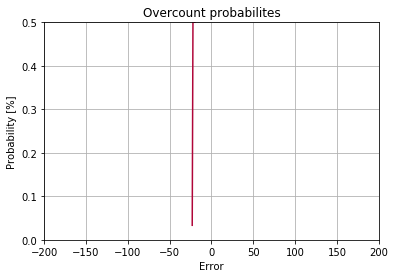

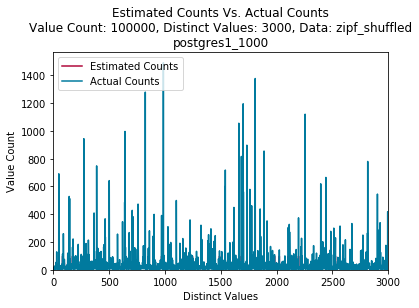

max error: 1393
max relative error: 716.666666667%
Estimation Technique: postgres1_1000
Sample Size: 3000
Mean Error: 24.1556666667
Mean Squared Error: 7841.161
Column Size [kB](uint16_t): 200.0



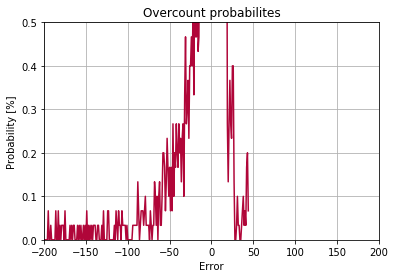

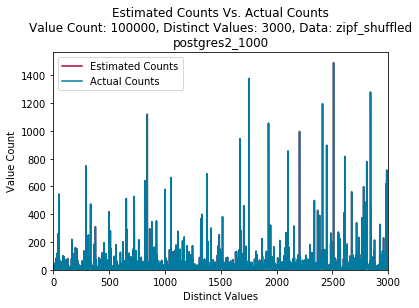

max error: 8
max relative error: 80.0%
Estimation Technique: postgres2_1000
Sample Size: 3000
Mean Error: 1.72033333333
Mean Squared Error: 6.71433333333
Column Size [kB](uint16_t): 200.0



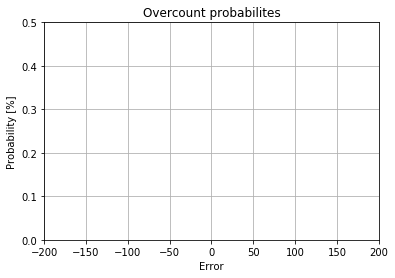

Estimation Technique  Memory Consumption  Mean Error  Mean Squared Error
0               uniform                 1.0    0.000000            0.000000
1          postgres1_10                40.0    0.000000            0.000000
2          postgres1_50               200.0    0.000000            0.000000
3         postgres1_100               400.0    0.000000            0.000000
4          postgres2_10                40.0    0.000000            0.000000
5          postgres2_50               200.0    0.000000            0.000000
6         postgres2_100               400.0    0.000000            0.000000
7           filter_14_4             12288.0    0.375210           12.532212
8           filter_14_8             20480.0    0.023892            0.788436
9          filter_14_16             36864.0    0.000088            0.002904
10          filter_15_2             16384.0    0.747670           25.221966
11          filter_15_4             24576.0    0.186780            6.244326
12          filter_15_8             40960.0    0.011594            0.382602
13         filter_15_16             73728.0    0.000154            0.005082
14          filter_16_2             32768.0    0.374616           12.499542
15          filter_16_4             49152.0    0.095304            3.151566
16          filter_16_8             81920.0    0.006226            0.205458
17         filter_16_16            147456.0    0.000154            0.005082

Estimation Technique  Memory Consumption  Mean Error  Mean Squared Error
0           filter_14_4             12288.0    0.375210           12.532212
1           filter_14_8             20480.0    0.023892            0.788436
2          filter_14_16             36864.0    0.000088            0.002904
3           filter_15_2             16384.0    0.747670           25.221966
4           filter_15_4             24576.0    0.186780            6.244326
5           filter_15_8             40960.0    0.011594            0.382602
6          filter_15_16             73728.0    0.000154            0.005082
7           filter_16_2             32768.0    0.374616           12.499542
8           filter_16_4             49152.0    0.095304            3.151566
9           filter_16_8             81920.0    0.006226            0.205458
10         filter_16_16            147456.0    0.000154            0.005082

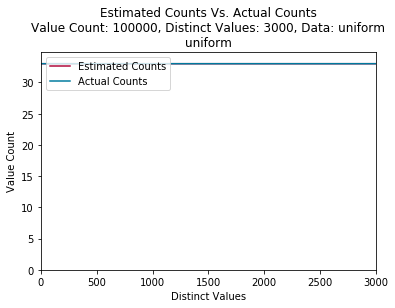

max error: 0
max relative error: 0%
Estimation Technique: uniform
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



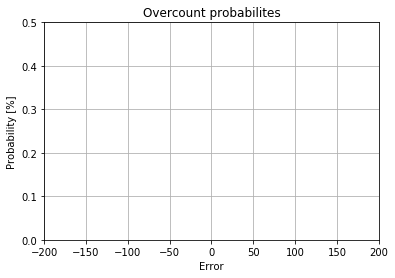

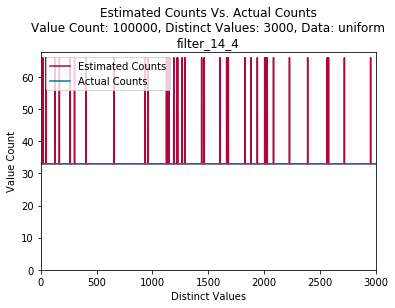

max error: 33
max relative error: 100.0%
Estimation Technique: filter_14_4
Sample Size: 3000000
Mean Error: 0.37521
Mean Squared Error: 12.532212
Column Size [kB](uint16_t): 200.0



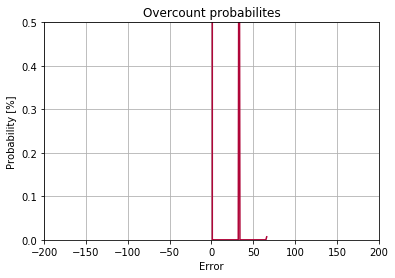

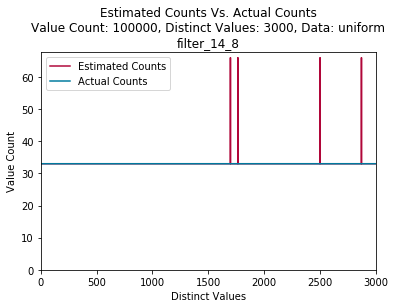

max error: 33
max relative error: 100.0%
Estimation Technique: filter_14_8
Sample Size: 3000000
Mean Error: 0.023892
Mean Squared Error: 0.788436
Column Size [kB](uint16_t): 200.0



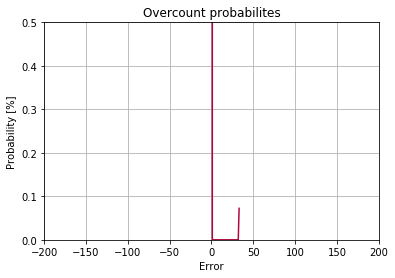

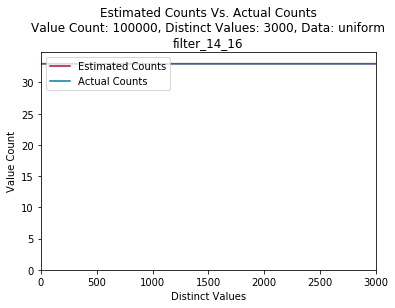

max error: 0
max relative error: 0%
Estimation Technique: filter_14_16
Sample Size: 3000000
Mean Error: 8.8e-05
Mean Squared Error: 0.002904
Column Size [kB](uint16_t): 200.0



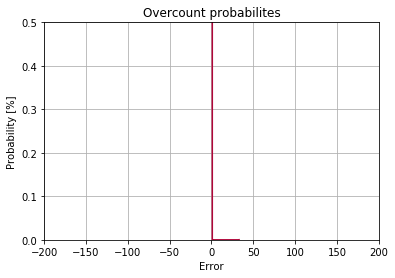

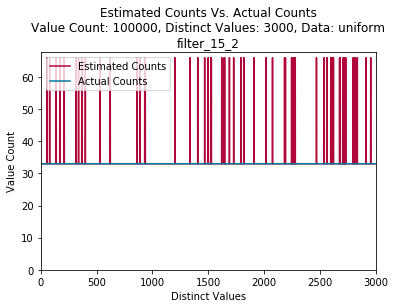

max error: 33
max relative error: 100.0%
Estimation Technique: filter_15_2
Sample Size: 3000000
Mean Error: 0.74767
Mean Squared Error: 25.221966
Column Size [kB](uint16_t): 200.0



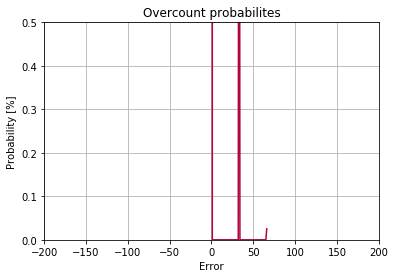

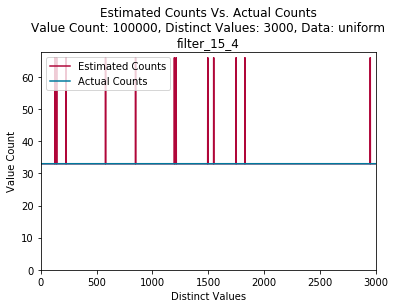

max error: 33
max relative error: 100.0%
Estimation Technique: filter_15_4
Sample Size: 3000000
Mean Error: 0.18678
Mean Squared Error: 6.244326
Column Size [kB](uint16_t): 200.0



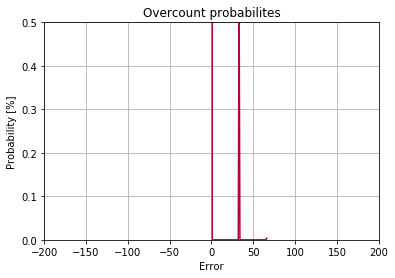

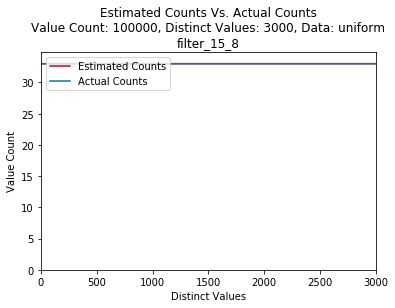

max error: 0
max relative error: 0%
Estimation Technique: filter_15_8
Sample Size: 3000000
Mean Error: 0.011594
Mean Squared Error: 0.382602
Column Size [kB](uint16_t): 200.0



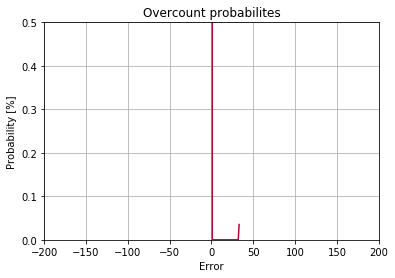

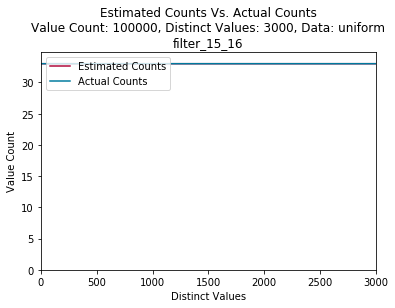

max error: 0
max relative error: 0%
Estimation Technique: filter_15_16
Sample Size: 3000000
Mean Error: 0.000154
Mean Squared Error: 0.005082
Column Size [kB](uint16_t): 200.0



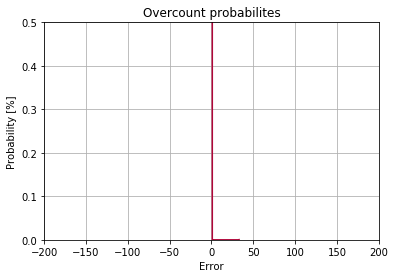

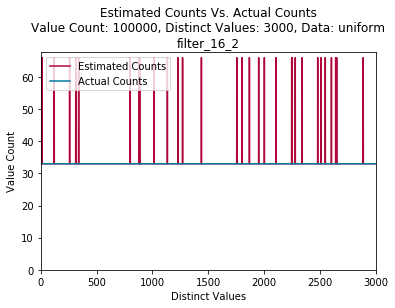

max error: 33
max relative error: 100.0%
Estimation Technique: filter_16_2
Sample Size: 3000000
Mean Error: 0.374616
Mean Squared Error: 12.499542
Column Size [kB](uint16_t): 200.0



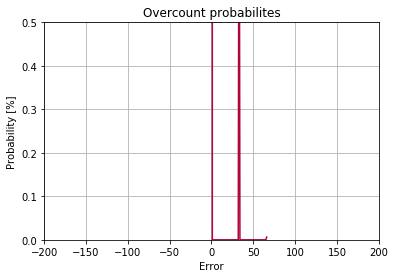

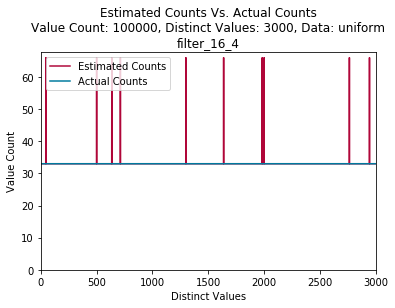

max error: 33
max relative error: 100.0%
Estimation Technique: filter_16_4
Sample Size: 3000000
Mean Error: 0.095304
Mean Squared Error: 3.151566
Column Size [kB](uint16_t): 200.0



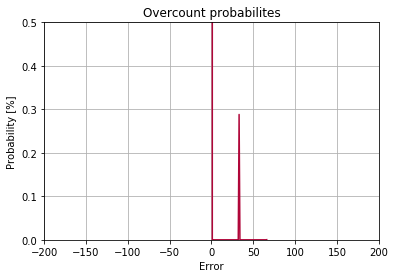

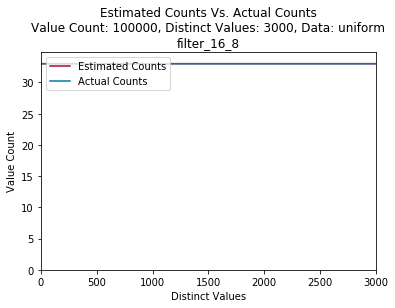

max error: 0
max relative error: 0%
Estimation Technique: filter_16_8
Sample Size: 3000000
Mean Error: 0.006226
Mean Squared Error: 0.205458
Column Size [kB](uint16_t): 200.0



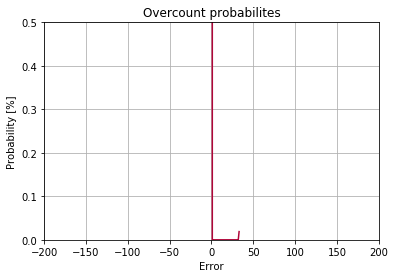

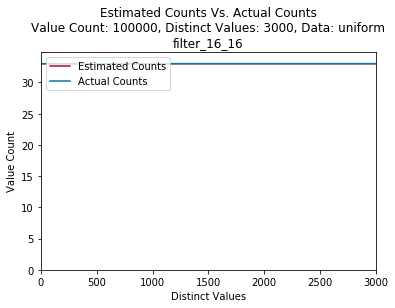

max error: 0
max relative error: 0%
Estimation Technique: filter_16_16
Sample Size: 3000000
Mean Error: 0.000154
Mean Squared Error: 0.005082
Column Size [kB](uint16_t): 200.0



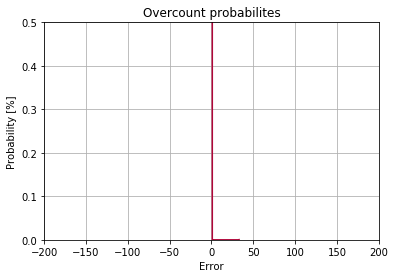

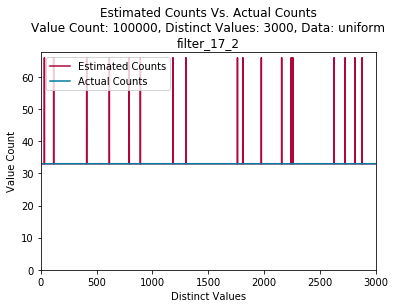

max error: 33
max relative error: 100.0%
Estimation Technique: filter_17_2
Sample Size: 3000000
Mean Error: 0.188144
Mean Squared Error: 6.271914
Column Size [kB](uint16_t): 200.0



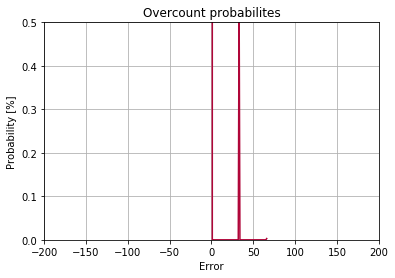

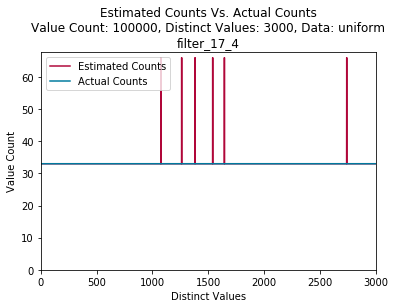

max error: 33
max relative error: 100.0%
Estimation Technique: filter_17_4
Sample Size: 3000000
Mean Error: 0.050314
Mean Squared Error: 1.666896
Column Size [kB](uint16_t): 200.0



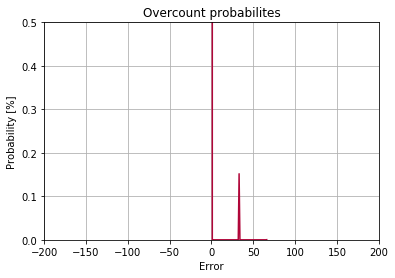

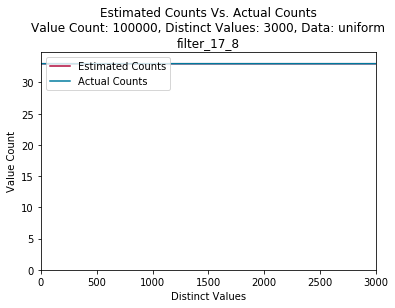

max error: 0
max relative error: 0%
Estimation Technique: filter_17_8
Sample Size: 3000000
Mean Error: 0.002662
Mean Squared Error: 0.087846
Column Size [kB](uint16_t): 200.0



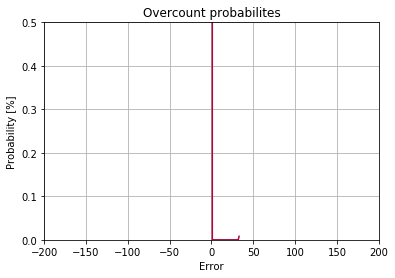

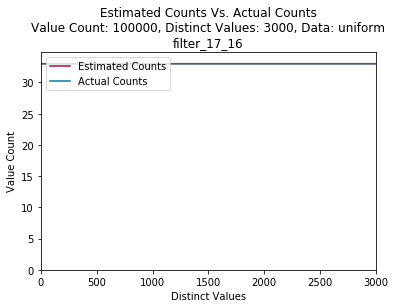

max error: 0
max relative error: 0%
Estimation Technique: filter_17_16
Sample Size: 3000000
Mean Error: 2.2e-05
Mean Squared Error: 0.000726
Column Size [kB](uint16_t): 200.0



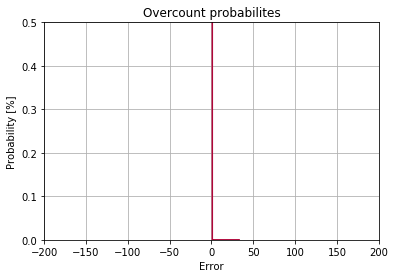

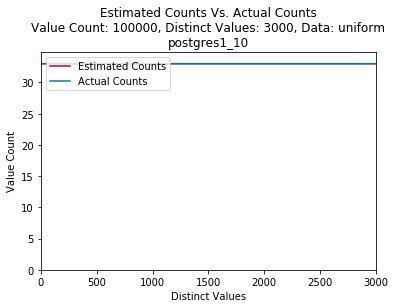

max error: 0
max relative error: 0%
Estimation Technique: postgres1_10
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



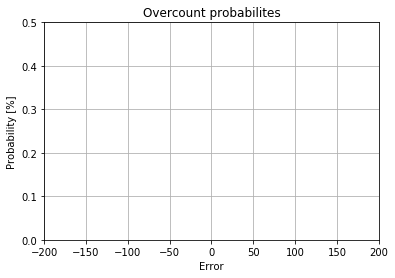

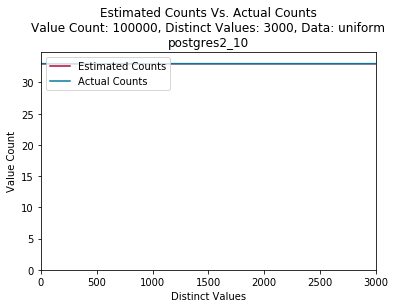

max error: 0
max relative error: 0%
Estimation Technique: postgres2_10
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



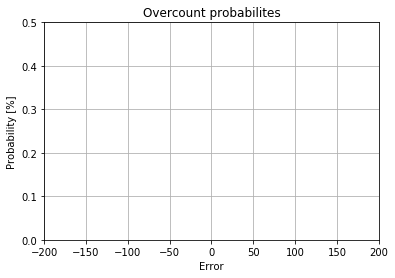

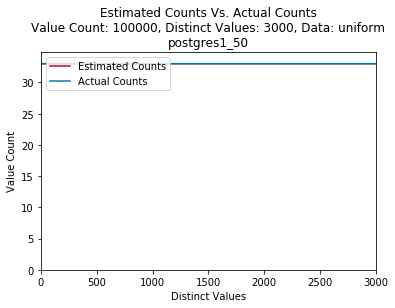

max error: 0
max relative error: 0%
Estimation Technique: postgres1_50
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



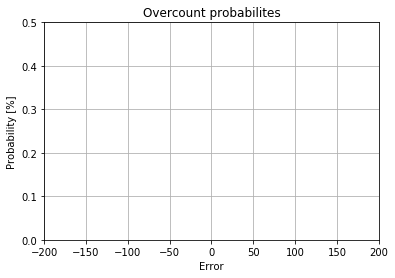

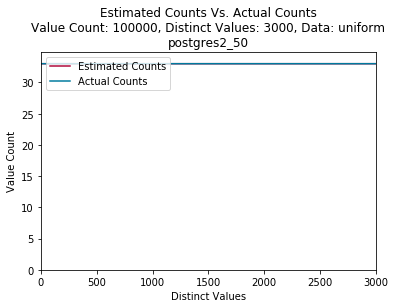

max error: 0
max relative error: 0%
Estimation Technique: postgres2_50
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



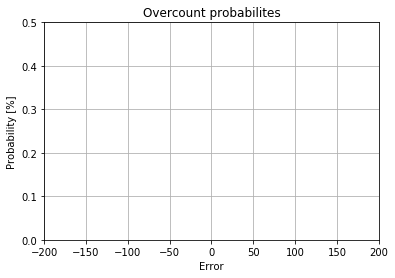

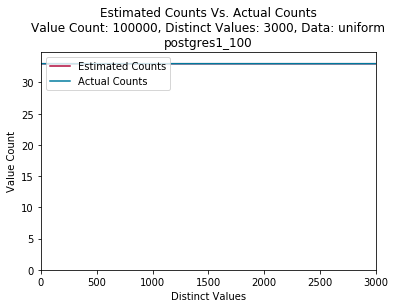

max error: 0
max relative error: 0%
Estimation Technique: postgres1_100
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



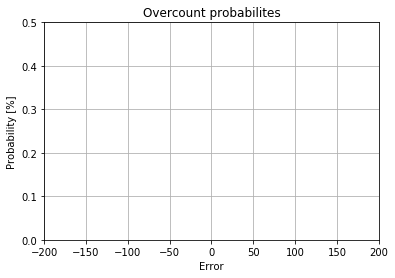

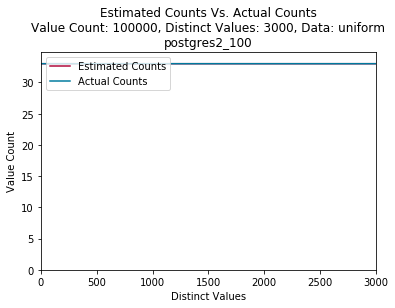

max error: 0
max relative error: 0%
Estimation Technique: postgres2_100
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



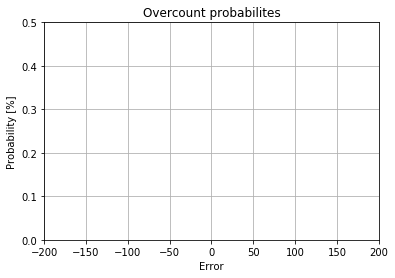

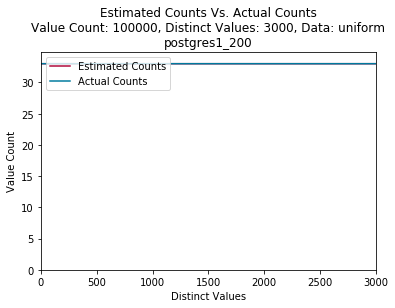

max error: 0
max relative error: 0%
Estimation Technique: postgres1_200
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



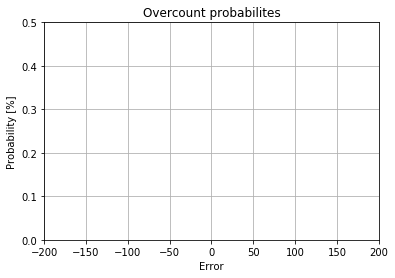

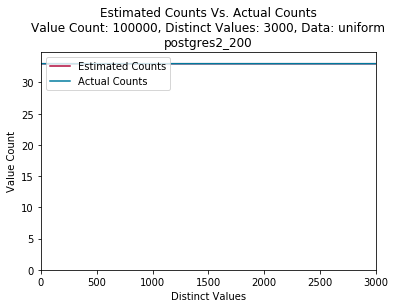

max error: 0
max relative error: 0%
Estimation Technique: postgres2_200
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



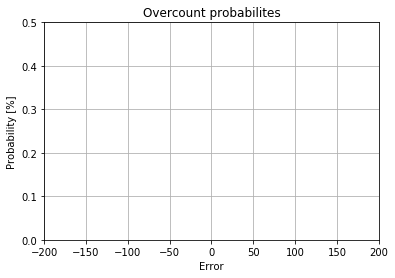

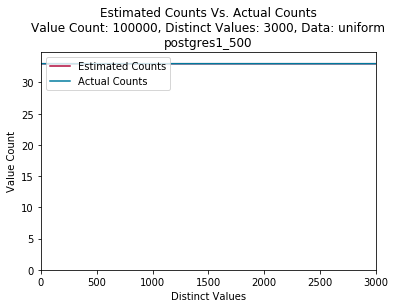

max error: 0
max relative error: 0%
Estimation Technique: postgres1_500
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



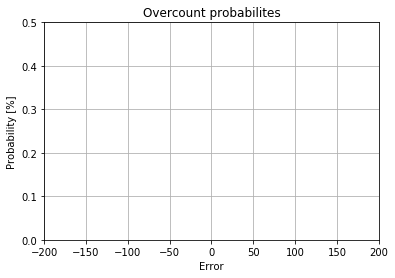

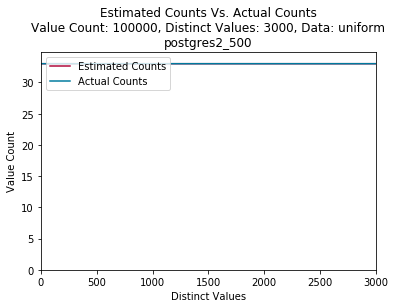

max error: 0
max relative error: 0%
Estimation Technique: postgres2_500
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



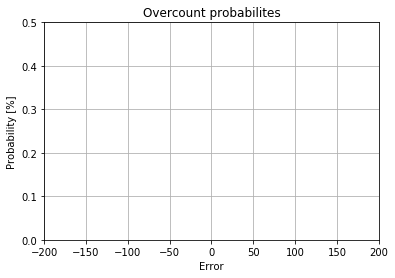

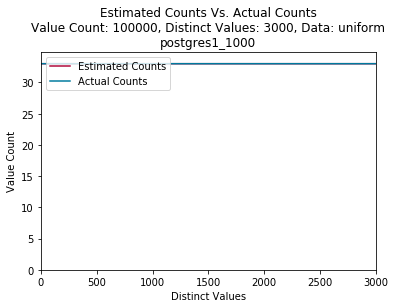

max error: 0
max relative error: 0%
Estimation Technique: postgres1_1000
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



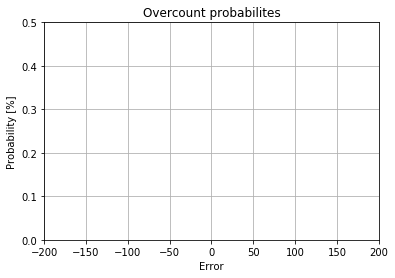

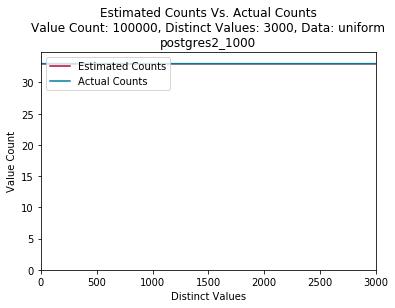

max error: 0
max relative error: 0%
Estimation Technique: postgres2_1000
Sample Size: 3000
Mean Error: 0.0
Mean Squared Error: 0.0
Column Size [kB](uint16_t): 200.0



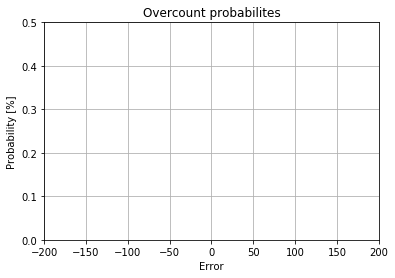

In [7]:
# Generate all plots
data_names = ["normal", "normal_shuffled", "zipf", "zipf_shuffled", "uniform"]
distinct_values = 3000
row_count = 100000
remainder_sizes = [2, 4, 8, 16]
quotient_sizes = [12, 13, 14, 15, 16, 17]
granularities = [10, 50, 100, 200, 500, 1000]

for data_name in data_names:
    complete_estimation_table(data_name, row_count, distinct_values)
    filter_estimation_table(data_name, row_count, distinct_values)

    estimation_example(data_name, row_count, distinct_values, "uniform")
    estimation_evaluation(data_name, row_count, distinct_values, "uniform")

    for estimation_tec in filter_names(quotient_sizes, remainder_sizes):
        estimation_example(data_name, row_count, distinct_values, estimation_tec)  
        estimation_evaluation(data_name, row_count, distinct_values, estimation_tec)

    for granularity in granularities:
        estimation_example(data_name, row_count, distinct_values, "postgres1_" + str(granularity))  
        estimation_evaluation(data_name, row_count, distinct_values, "postgres1_" + str(granularity))
        estimation_example(data_name, row_count, distinct_values, "postgres2_" + str(granularity))  
        estimation_evaluation(data_name, row_count, distinct_values, "postgres2_" + str(granularity))  

distinct values: 99


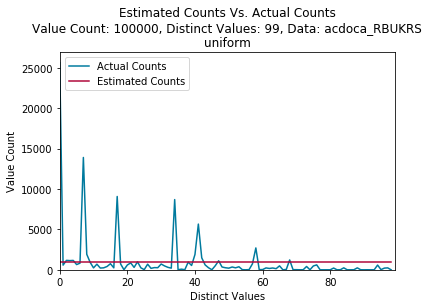

C:\Users\Arne\Anaconda3\lib\site-packages\ipykernel_launcher.py:170: RuntimeWarning: divide by zero encountered in longlong_scalars


max error: 24618
max relative error: 100400.0%
Estimation Technique: uniform
Sample Size: 99
Mean Error: 1265.27272727
Mean Squared Error: 9854754.42424
Column Size [kB](uint16_t): 200.0



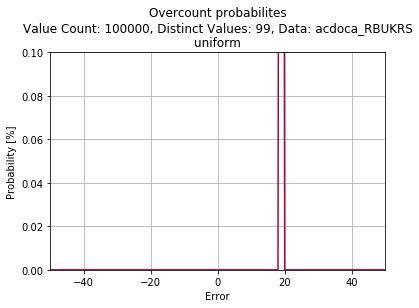

In [13]:
# Generate all plots
#"BELNR", "RBUKRS", "KUNNR", "RYEAR", "EBELN", "BUZEI"
data_names = ["acdoca_RBUKRS"]
row_count = 100000
remainder_sizes = [2, 4, 8, 16]
quotient_sizes = [12, 13, 14, 15, 16, 17]
granularities = [10, 50, 100, 200, 500, 1000]


for data_name in data_names:
    data = get_results("estimation")
    distinct_values = data[(data.data_name == data_name)]["distinct_values"].iloc[0]
    print("distinct values: " + str(distinct_values))
    #complete_estimation_table(data_name, row_count, distinct_values)
    #filter_estimation_table(data_name, row_count, distinct_values)

    estimation_example(data_name, row_count, distinct_values, "uniform")
    estimation_evaluation(data_name, row_count, distinct_values, "uniform")

    #for estimation_tec in filter_names(quotient_sizes, remainder_sizes):
    #    estimation_example(data_name, row_count, distinct_values, estimation_tec)  
    #    estimation_evaluation(data_name, row_count, distinct_values, estimation_tec)

    #for granularity in granularities:
    #    estimation_example(data_name, row_count, distinct_values, "postgres1_" + str(granularity))  
    #    estimation_evaluation(data_name, row_count, distinct_values, "postgres1_" + str(granularity))
    #    estimation_example(data_name, row_count, distinct_values, "postgres2_" + str(granularity))  
    #    estimation_evaluation(data_name, row_count, distinct_values, "postgres2_" + str(granularity))  